# Transforming

This notebook reads in the data and removes the apperent trend and seasonality in the time series to obtain a stationary time series.

In [468]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as ss
from statsmodels.tsa.stattools import adfuller

%matplotlib notebook
#plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots

from datetime import datetime

### Read in data

In [449]:
df = pd.read_csv("Data/monthly_in_situ_co2_mlo.csv", 
                 na_values=-99.99, 
                 skiprows=55, 
                 skipfooter=6,engine='python')
df.drop([0, 1], axis=0, inplace=True)
df.reset_index(inplace=True)
df.drop(['Date Excel', 'index'], axis=1, inplace=True)
df = df[10:-6] #Skipt first and last year, because of many NaN values
df.tail(10)

Yr  Mn       Date  CO2[ppm]  seasonally adjusted[ppm]   fit[ppm]  \
720  2018   3  2018.2027    409.25                    407.71     409.38   
721  2018   4  2018.2877    410.30                    407.51     410.81   
722  2018   5  2018.3699    411.30                    407.91     411.58   
723  2018   6  2018.4548    410.88                    408.31     410.96   
724  2018   7  2018.5370    408.90                    408.08     409.44   
725  2018   8  2018.6219    407.10                    408.62     407.34   
726  2018   9  2018.7068    405.59                    409.08     405.67   
727  2018  10  2018.7890    405.99                    409.61     405.85   
728  2018  11  2018.8740    408.12                    410.38     407.50   
729  2018  12  2018.9562    409.23                    410.16     409.09   

     seasonally adjusted fit[ppm]  CO2 filled[ppm]  \
720                        407.82           409.25   
721                        408.00           410.30   
722                        408.19           411.30   
723                        408.41           410.88   
724                        408.65           408.90   
725                        408.91           407.10   
726                        409.18           405.59   
727                        409.45           405.99   
728                        409.73           408.12   
729                        410.00           409.23   

      seasonally adjusted filled[ppm]  
720                            407.71  
721                            407.51  
722                            407.91  
723                            408.31  
724                            408.08  
725                            408.62  
726                            409.08  
727                            409.61  
728                            410.38  
729                            410.16

The data-set contains some transformed values, but we will concentrate on the raw-data measurements (CO2[ppm])

In [450]:
df["Dato"] = df["Yr"].map(str) + "-" +df["Mn"].map(str) # Create new date-column with fromat YYYY-MM
df.Dato = pd.to_datetime(df['Dato'], format='%Y-%m') # change date to pandas-datetime format
df.set_index(['Dato'],inplace=True) #Set date as index
df = df.rename({"CO2[ppm]": 'CO2'}, axis=1)  # create new name for CO2-concentration column

In [451]:
df = df[["CO2"]] # We only need this column
df.fillna(321.20, inplace=True) # Forward filling the NaN values

### Plot of the time series

In [452]:
def plot_df(df, x, y, title="", xlabel='Dato', ylabel='CO2[ppm]'):
    
    """ Plots the given dataframe"""
    
    plt.figure(figsize=(16,8))
    plt.plot(x, y,linestyle="-")
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

<IPython.core.display.Javascript object>


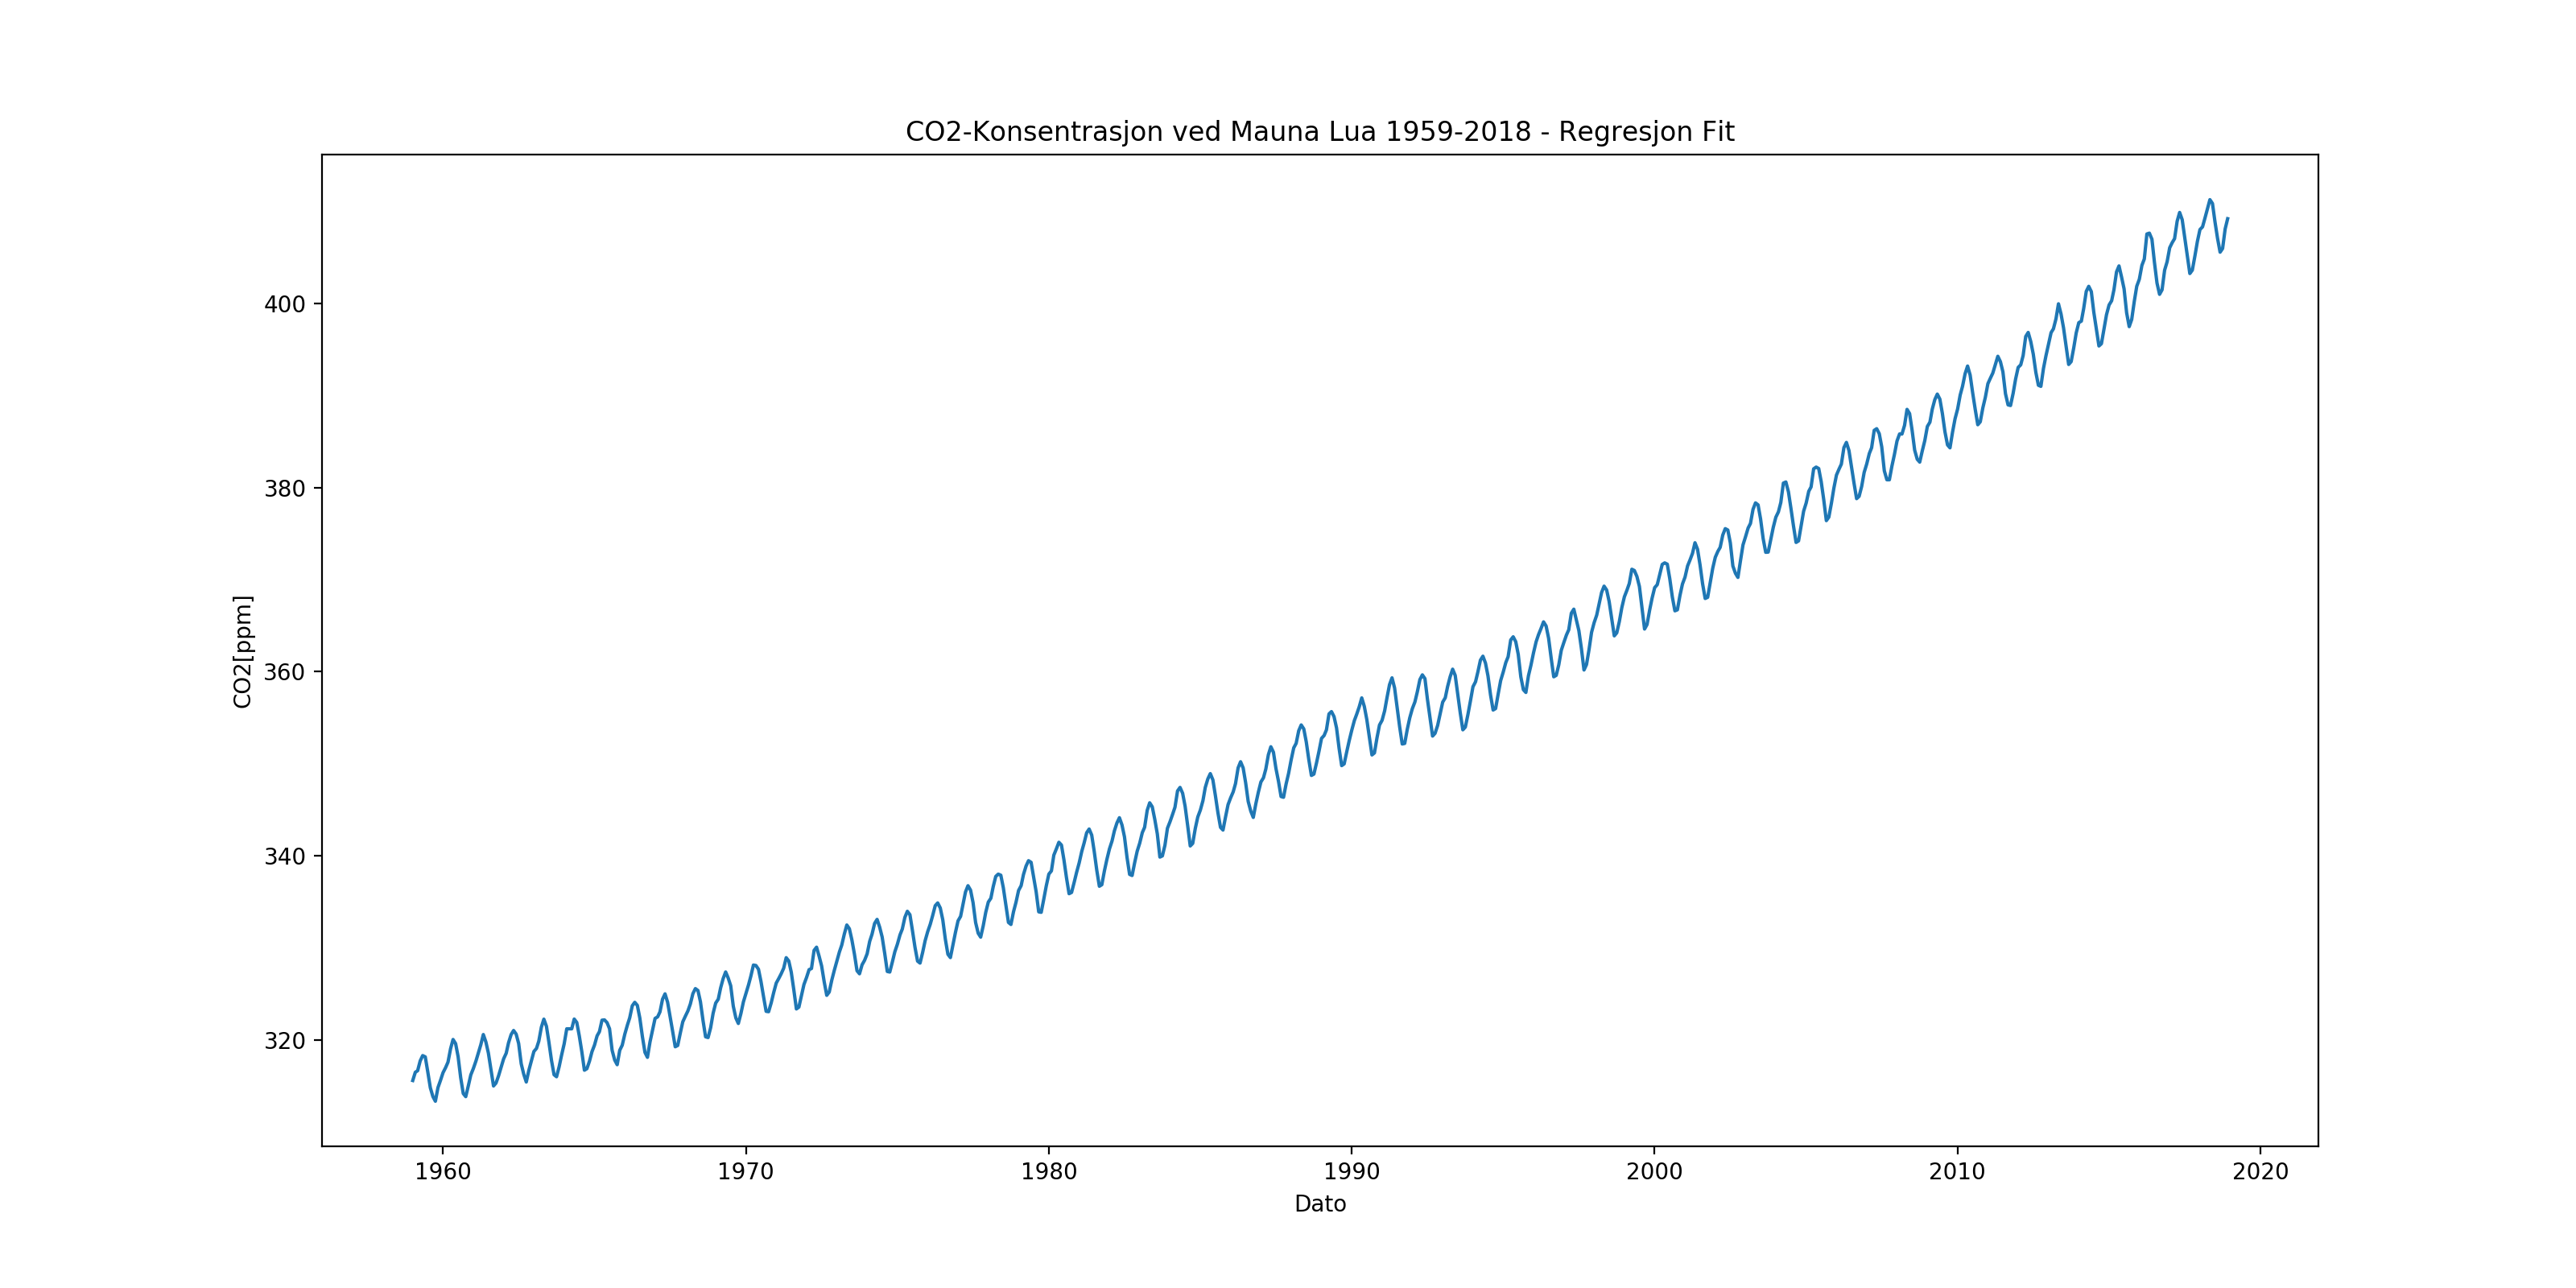

In [453]:
plot_df(df, x=df.index, y=df.CO2, title='CO2-Konsentrasjon ved Mauna Lua 1959-2018 - Regresjon Fit') 

### Estimating the trend and seasonal component

In [455]:
def moving_average(df, period):
    
    n = len(df.index) #antall data-punkter
    q = int(period/2)
    x = np.pad(df.CO2.values, q, 'edge')
    
    trend = np.zeros(n)

    for i in range(n):

        for j in range(-q,q+1):

            if (j == -q or j == q):
                k = 0.5
            else:
                k = 1

            trend[i] += k*x[q+i-j]

        trend[i] = trend[i]/(2.0*q)
    
    return trend

#### Estimating and removing the trend component

In [456]:
trend = moving_average(df, 12)
data_detrend = df.CO2.values - trend

In [457]:
df2 = df.copy(deep=True)
df2.CO2 = data_detrend

<IPython.core.display.Javascript object>


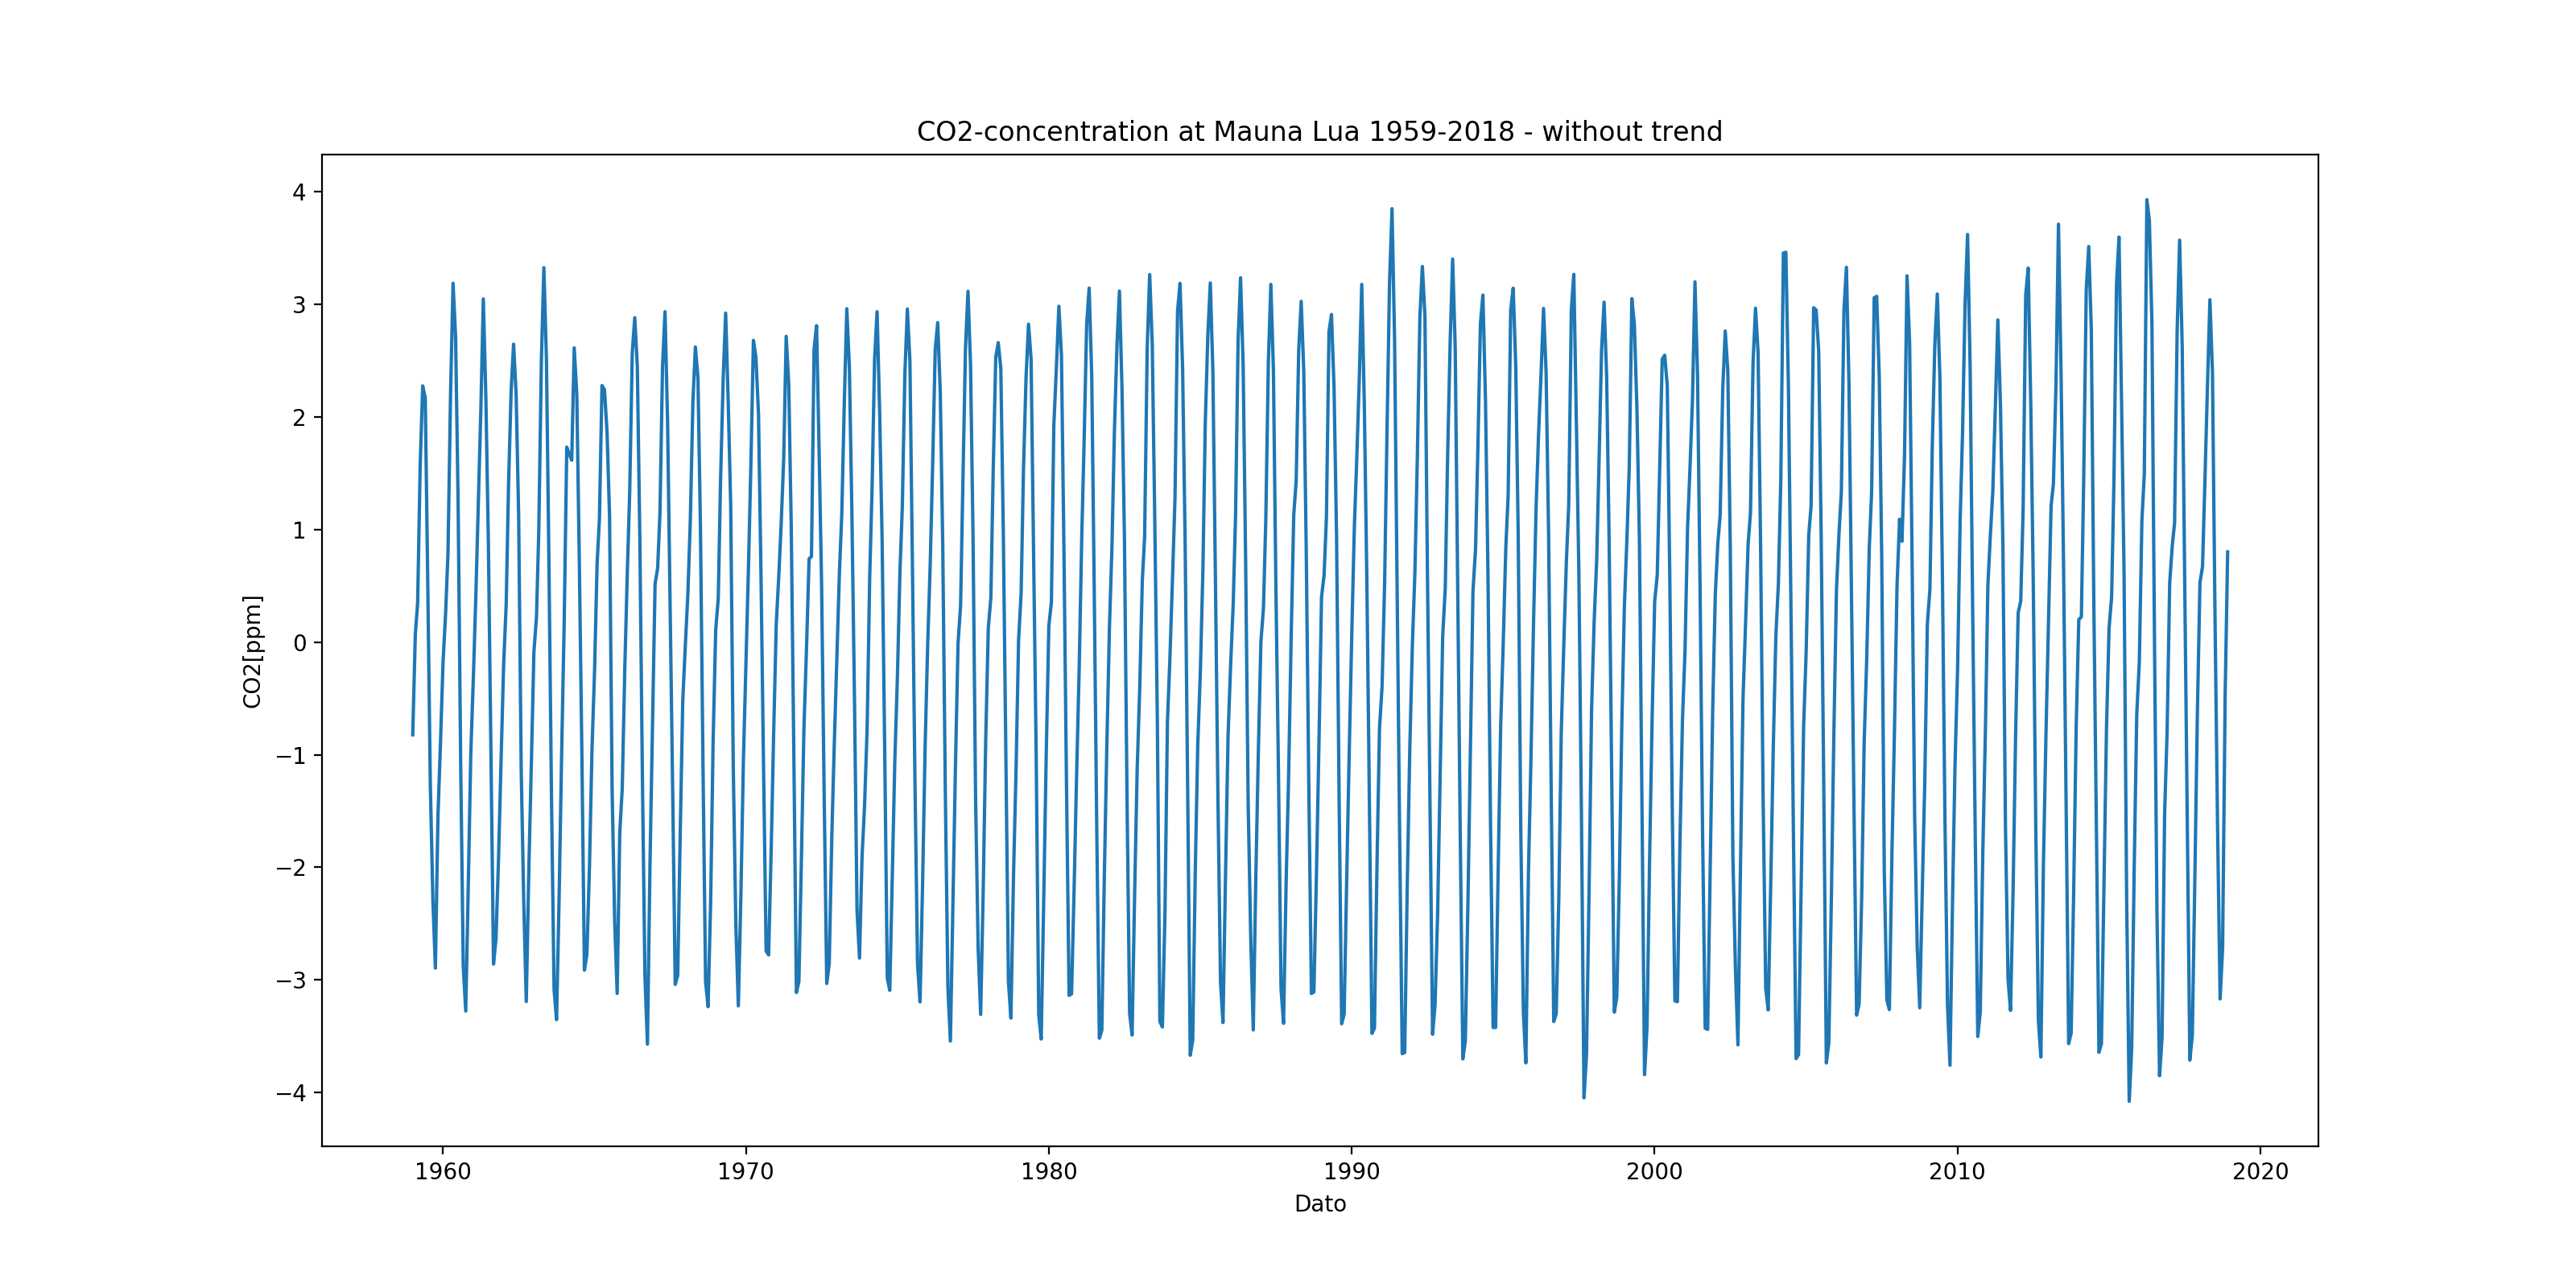

In [458]:
plot_df(df2, x=df2.index, y=df2.CO2, title='CO2-concentration at Mauna Lua 1959-2018 - without trend') 

#### Estemating and removing the seasonal component

First estimate the seasonal component:

In [460]:
data_years = data_detrend.reshape((60, 12)) #Reshape data so that each row contains data for a year
yearly_mean = np.mean(data_years, axis=0) #Get mean of each year
yearly_mean -= np.mean(yearly_mean) #Sum of means should be zero
seasonal_component = np.tile(yearly_mean,60) #length of data should be equal

Subtract the seasonal component from the detrended data:

In [461]:
data_transform1 = df.CO2.values - seasonal_component
df2.CO2 = data_transform1

We can then estimate the trend from the transformed data:

In [462]:
trend = moving_average(df2, 12)

Finally, we remove the trend and seasonal component from the original data to obtain the residuals.
The residuals are then stores in a dataframe.

In [463]:
residuals = df.CO2.values - trend - seasonal_component
df['trend'] = trend
df['seasonal_component'] = seasonal_component
df['residuals'] = residuals

<IPython.core.display.Javascript object>


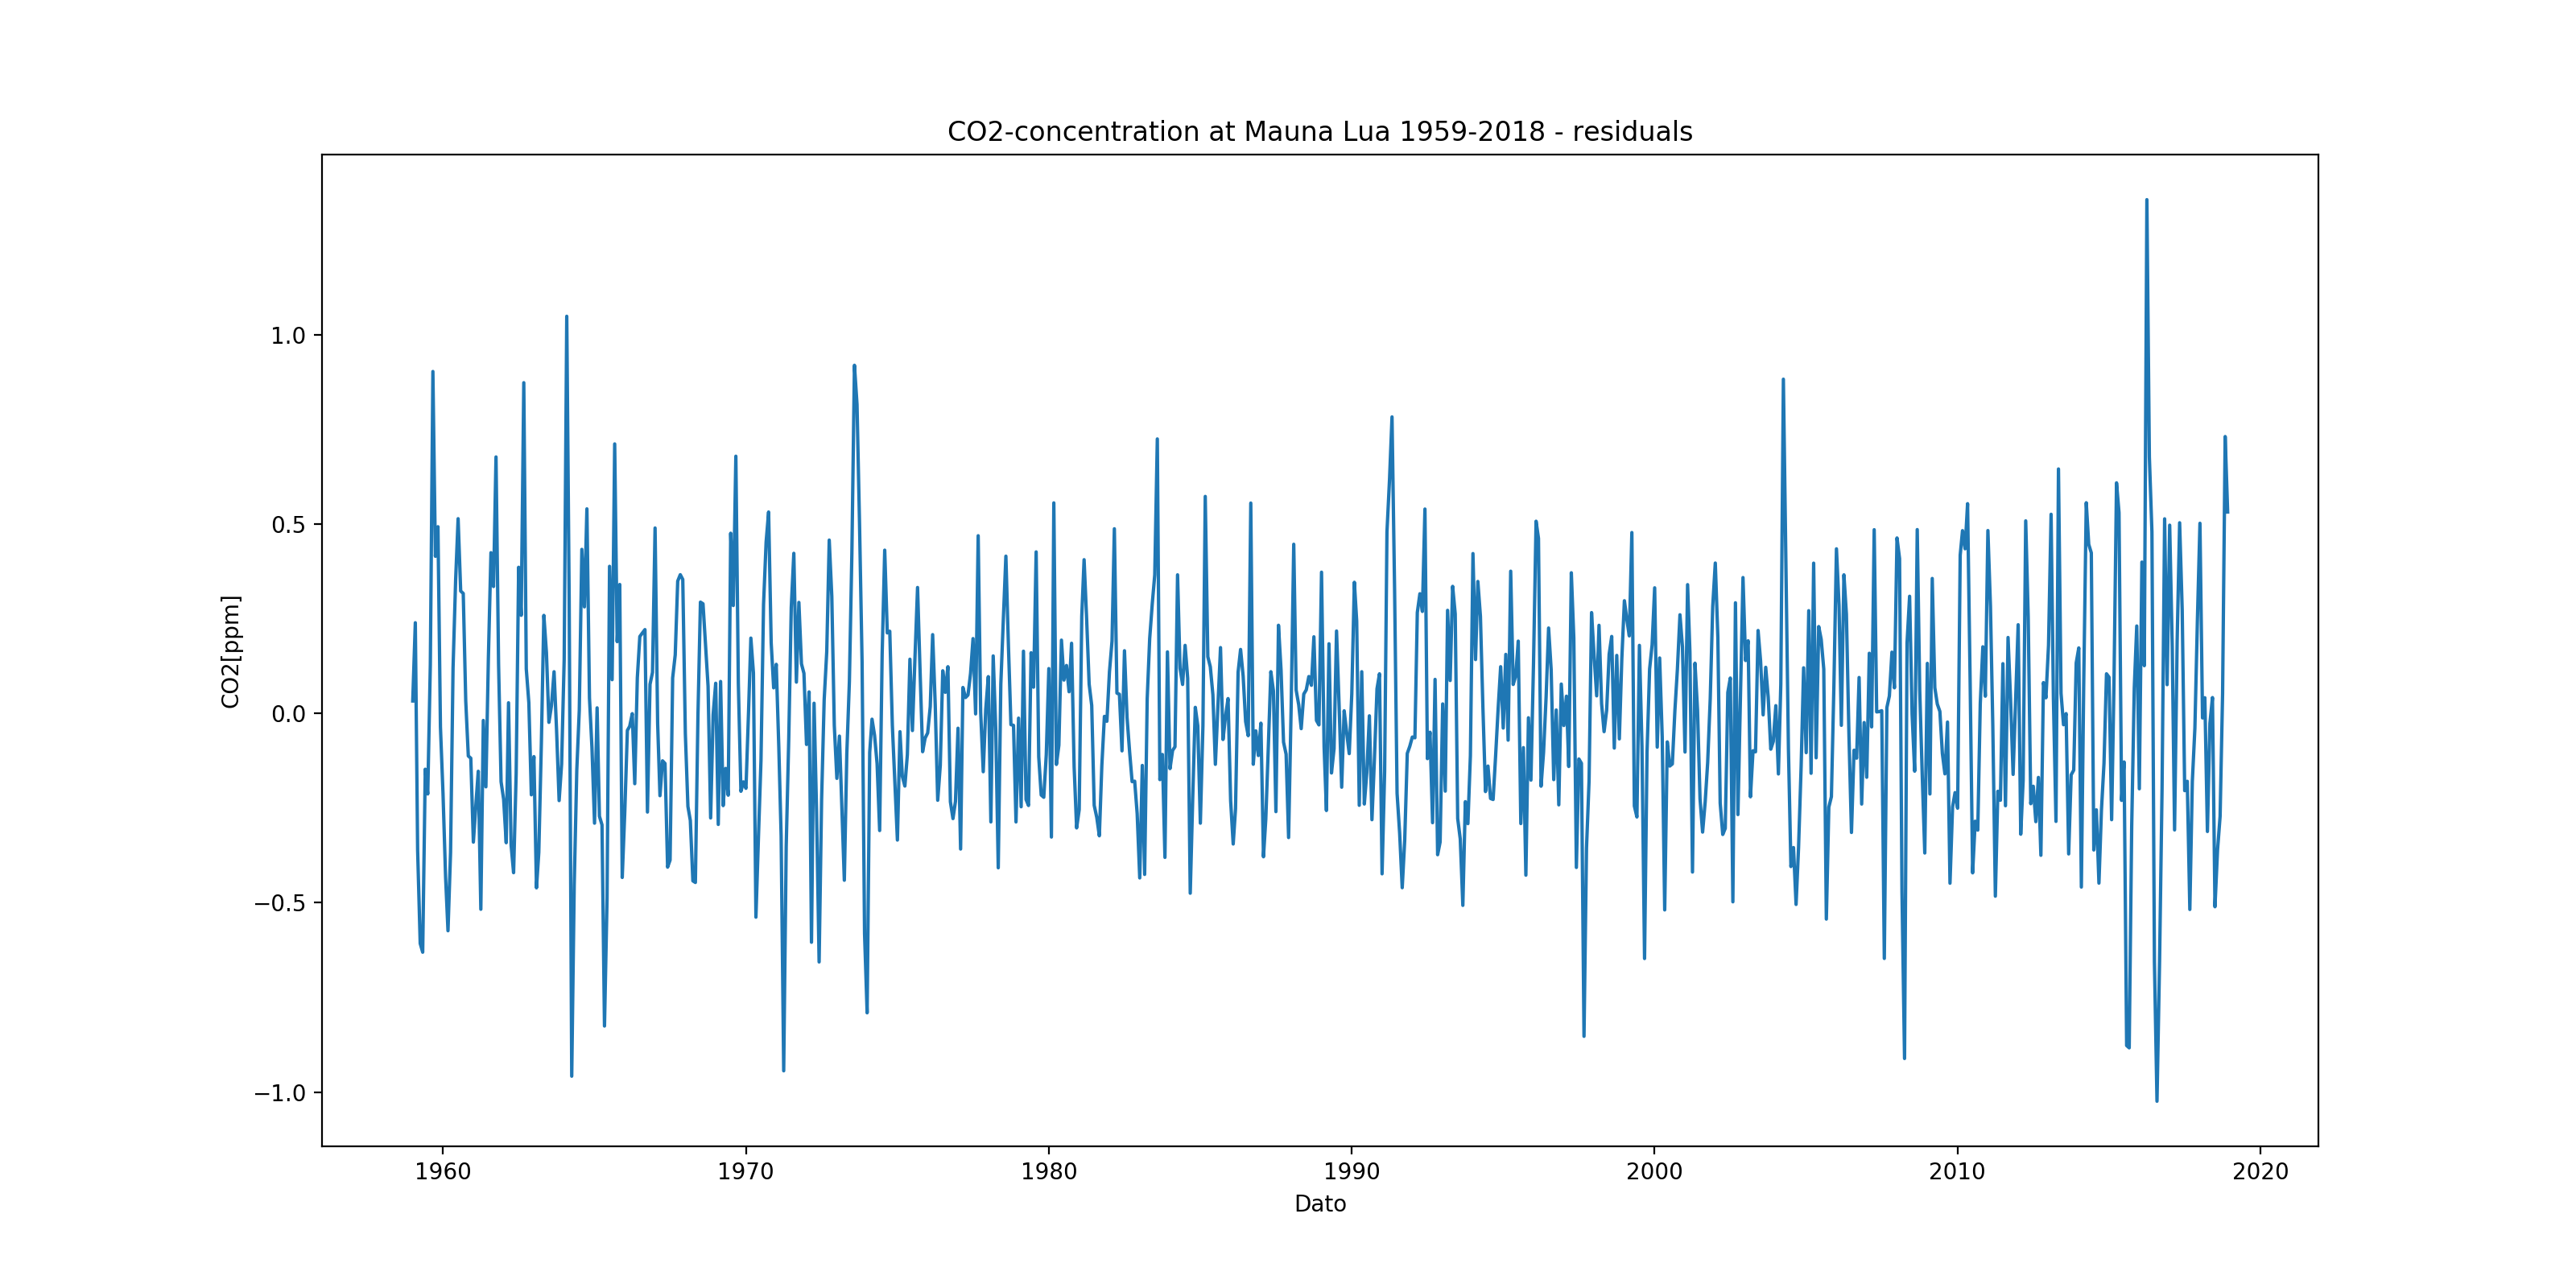

In [464]:
plot_df(df, x=df.index, y=df.residuals, title='CO2-concentration at Mauna Lua 1959-2018 - residuals') 

### Further differencing to remove additional seasonal components

In [466]:
one_shifted = df['residuals'].shift(1)
df['residuals_differenced'] = df['residuals'] - one_shifted

one_shifted = df['residuals_differenced'].shift(1)
df['residuals_differenced_2'] = df['residuals_differenced'] - one_shifted

df = df[12:]

<IPython.core.display.Javascript object>


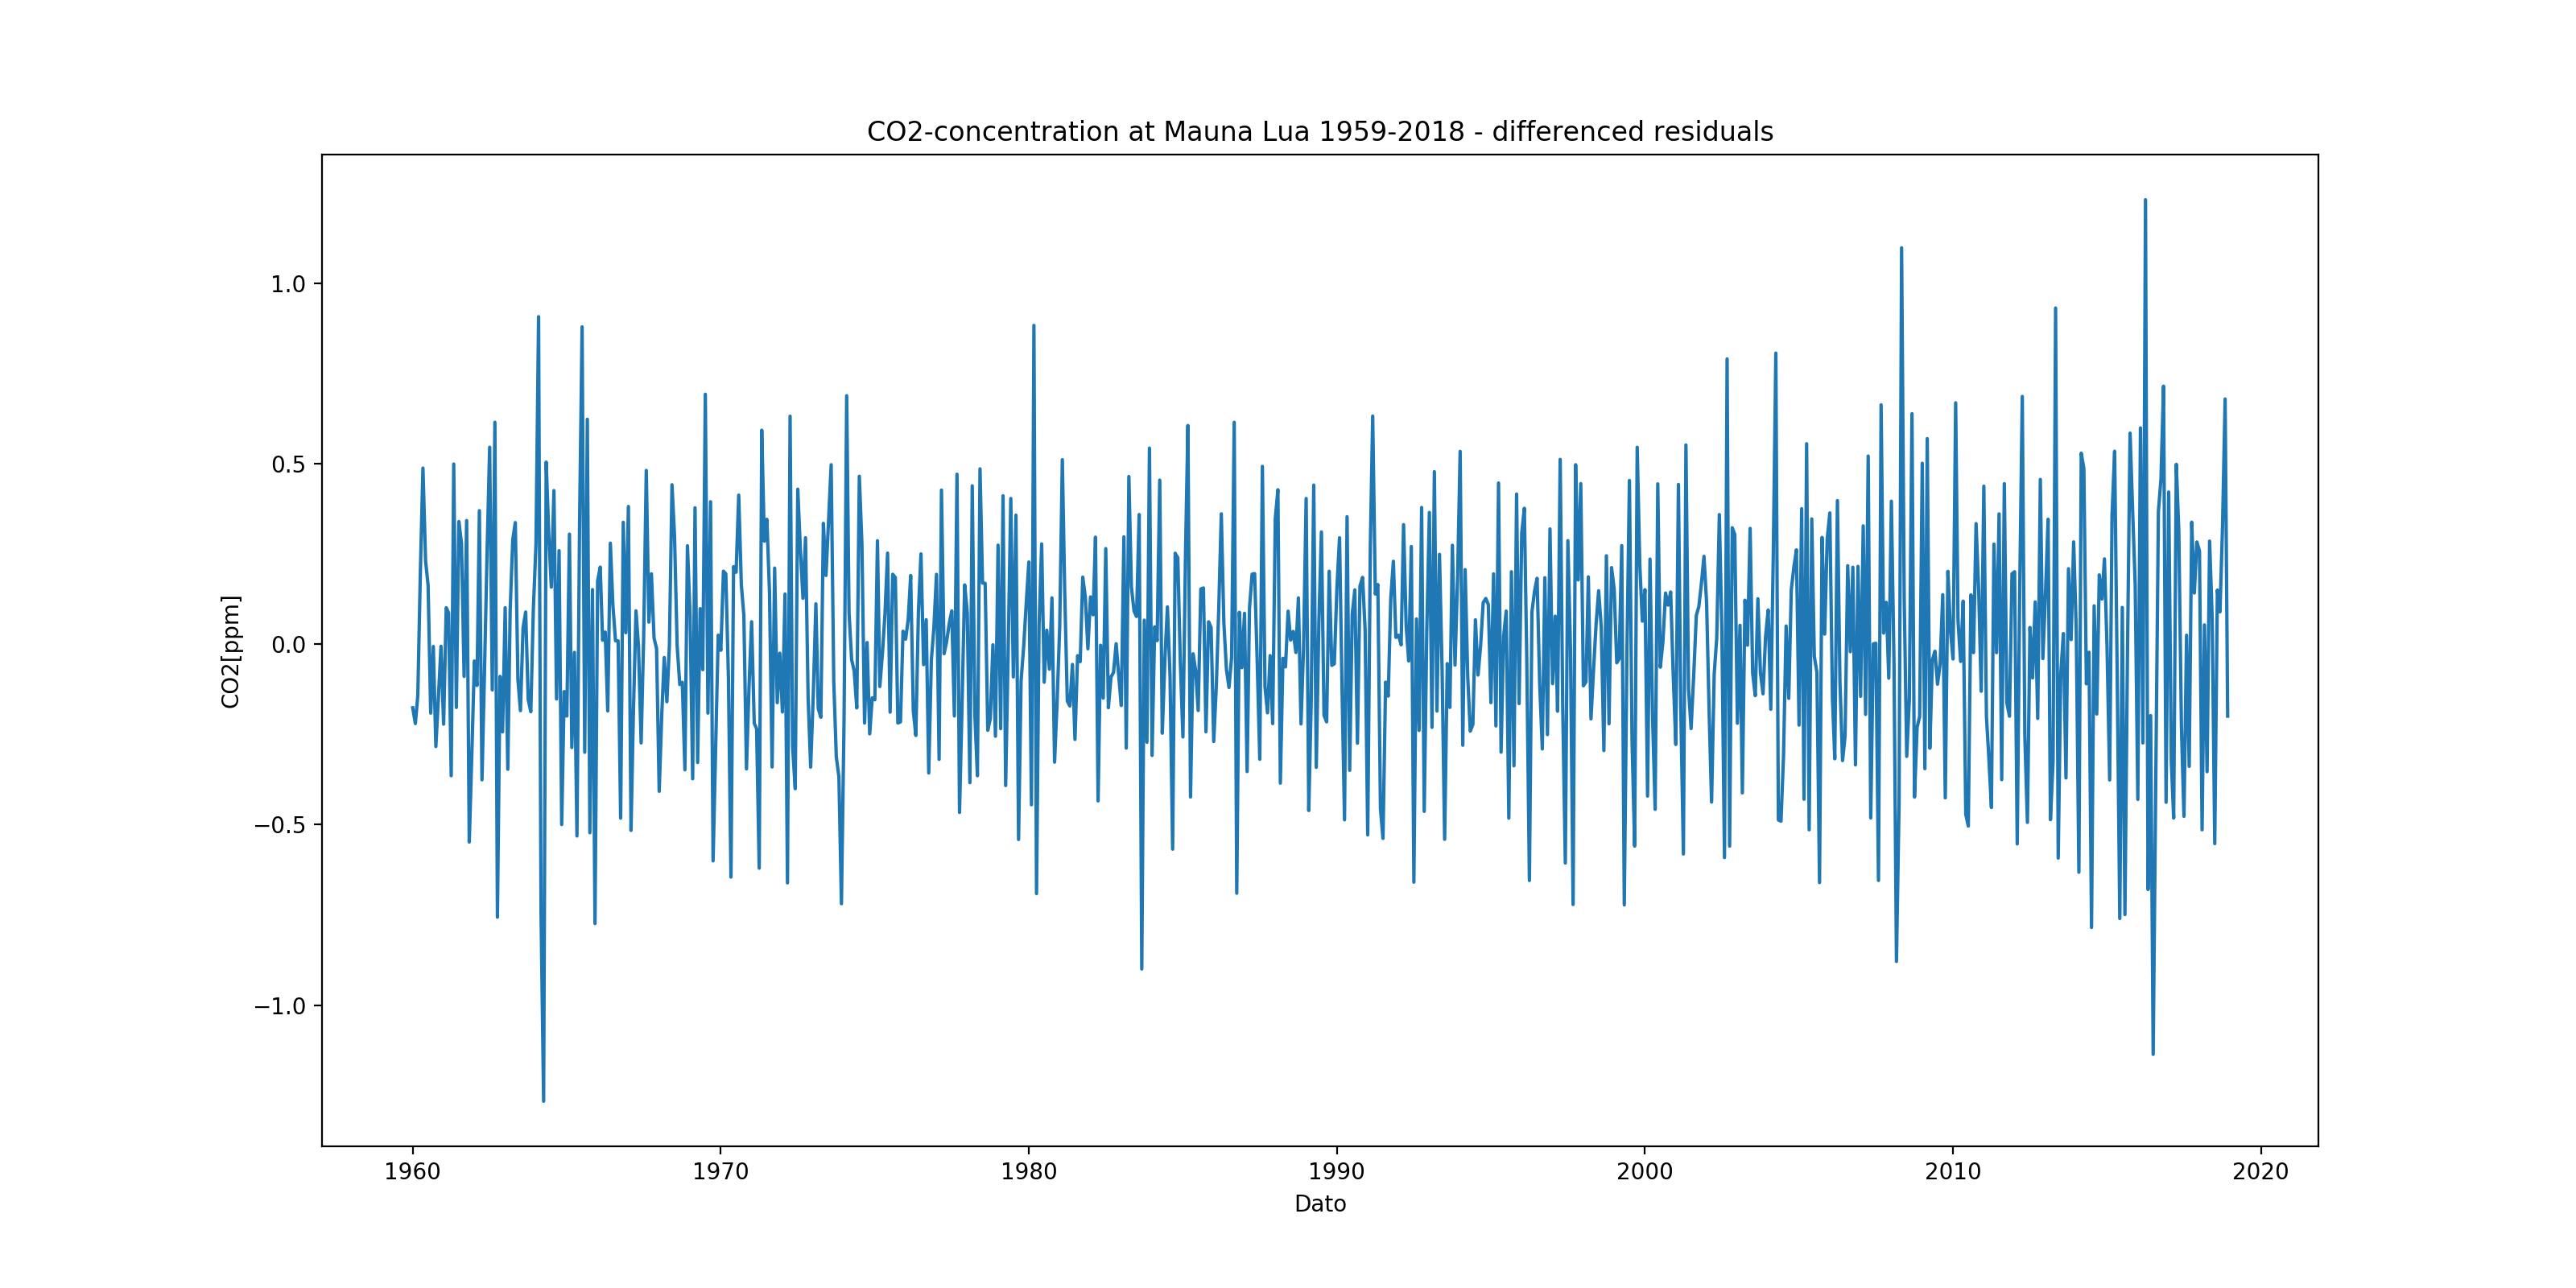

In [467]:
plot_df(df, x=df.index, y=df.residuals_differenced, title='CO2-concentration at Mauna Lua 1959-2018 - differenced residuals') 

### Autocorrelation

Inspecting the autocorrelation:

In [469]:
def gen_autocorr(series):
    length_sequence = series.size
    lag = np.array(range(-length_sequence + 1, length_sequence))
    autocorr = np.correlate(series.values, series.values, mode='full')
    autocorr = autocorr / (autocorr[length_sequence - 1]) # Normalize with regard to lag = 0
    return pd.Series(lag), pd.Series(autocorr)

lag, autocorr_residuals = gen_autocorr(df.residuals_differenced_2)

#### Plot of the autocorrelation between lags of the residuals

<IPython.core.display.Javascript object>


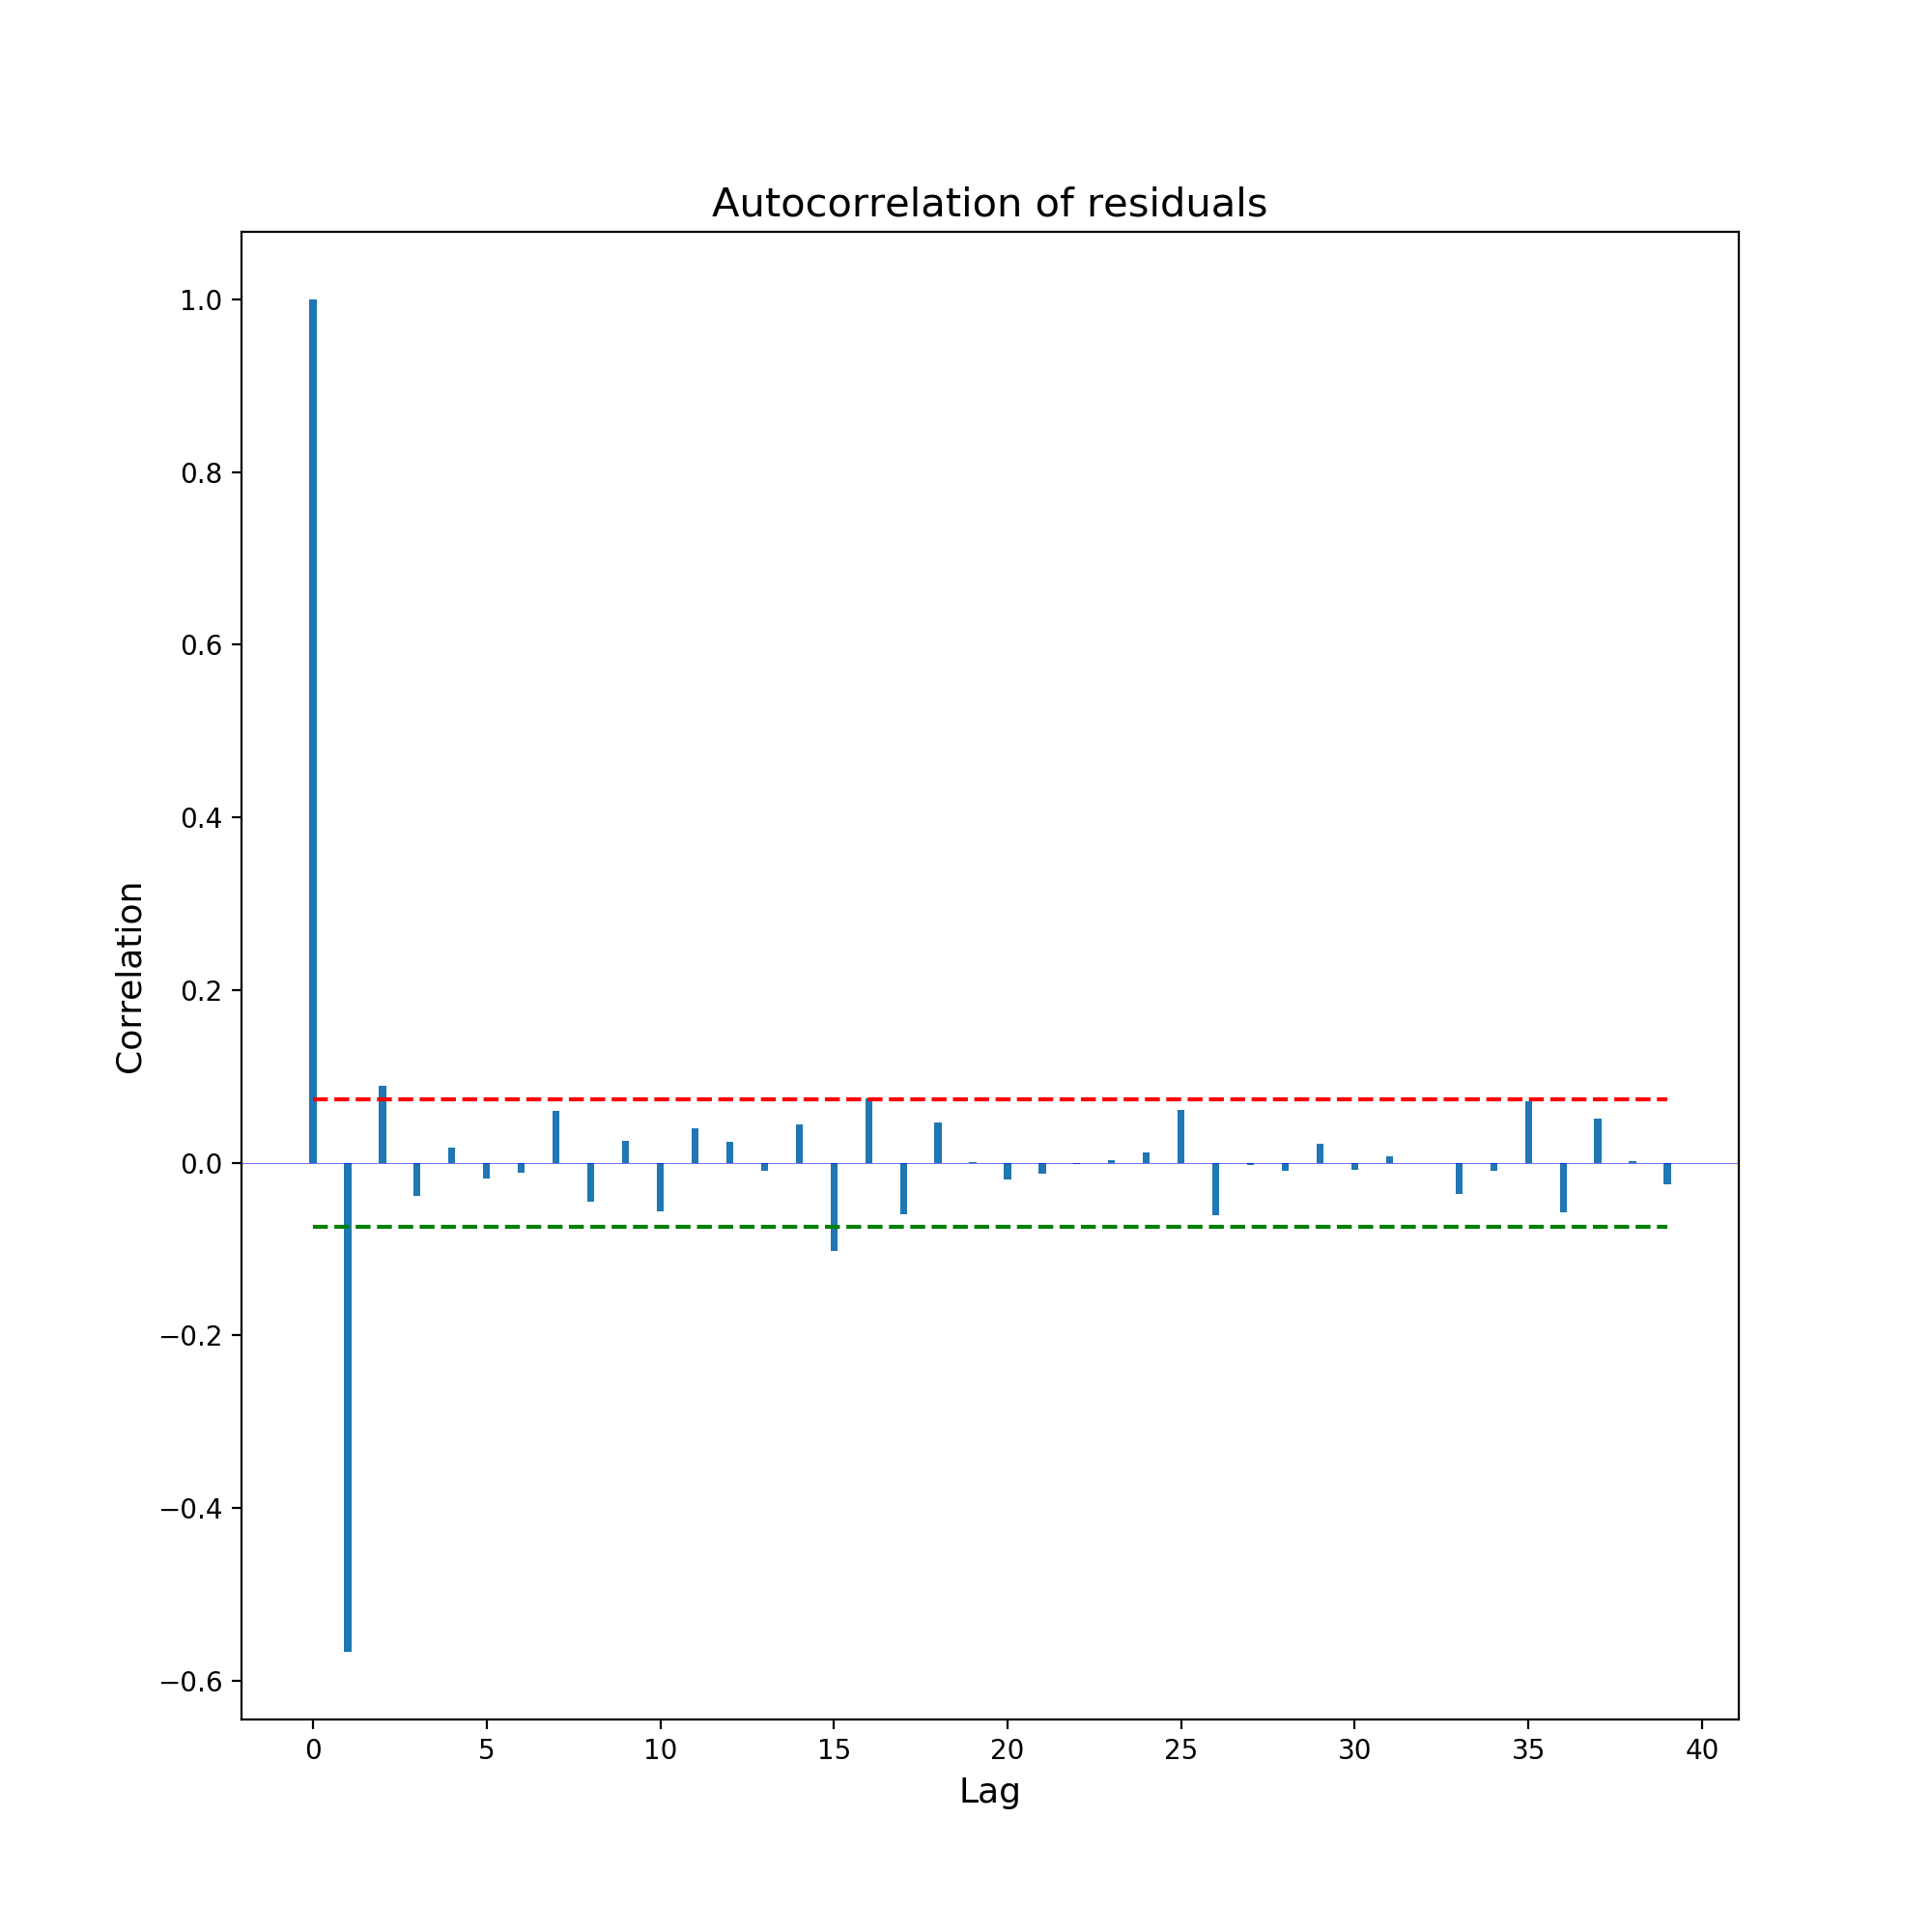

In [470]:
length_sequence = len(df.residuals_differenced)
# Boundarise
num = 1.96/np.sqrt(length_sequence)
upper = np.ones(2*length_sequence - 1)*num
lower = np.ones(2*length_sequence - 1)*(-num)

lim1 = length_sequence - 1
lim2 = length_sequence - 1 + 40

plt.figure(figsize=(10,10))
#plt.plot(lag[lim1:lim2], autocorr_residuals[lim1:lim2], lag[lim1:lim2], upper[lim1:lim2], lag[lim1:lim2], lower[lim1:lim2])
plt.bar(lag[lim1:lim2], autocorr_residuals[lim1:lim2], width=0.2)
plt.plot(lag[lim1:lim2], upper[lim1:lim2], 'r--',lag[lim1:lim2], lower[lim1:lim2],'g--')
plt.title('Autocorrelation of residuals', fontsize = 15)
plt.axhline(0, color='blue',lw=0.2)
plt.xlabel('Lag', fontsize=13)
plt.ylabel('Correlation', fontsize=13)
plt.show()

In [471]:
nr_el_outside_range = 0
for i in range(autocorr_residuals.shape[0]):
    if np.abs(autocorr_residuals[i]) > num:
        nr_el_outside_range += 1

print('Number of sample autocorrelations outside boundary', nr_el_outside_range / (2*length_sequence-1) * 100, '%')

Number of sample autocorrelations outside boundary 5.017667844522968 %


If a large number of values fall outside the bounds, we reject the hypothesis that the residuals are iid noise. 

### Check for stationarity

Using the Augmented Dickey-Fuller (ADF) test (https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)


The ADF-test tests for the presence of a unit root in the time series.
The null hypthesis is that there exists a unit root, and we reject the null-hypothesis if we observe a p-value below 0.05 (5 % significance level). The alternative hypothesis is that the time series is stationary.

In [472]:
result = adfuller(df.residuals_differenced)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.073587
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Since the p-value is clearly below 0.05, we reject the null-hypothesis in favor of the alternative hypothesis, and the residuals are therefore stationary.

We can also check for stationarity in the original data:

In [473]:
result = adfuller(df.CO2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 4.646847
p-value: 1.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Since the p-value is clearly above 0.05, we cannot the reject the null-hyptothesis and the precence of a unit root.
This shows that the removal of trend and seasonal components above has transformed the data from a non-stationary time-series to a stationary time series.

### Checking for normality

Q-Q plot to check for normality of residuals.
The plot should be linear if the residuals are normally distributed.

<IPython.core.display.Javascript object>


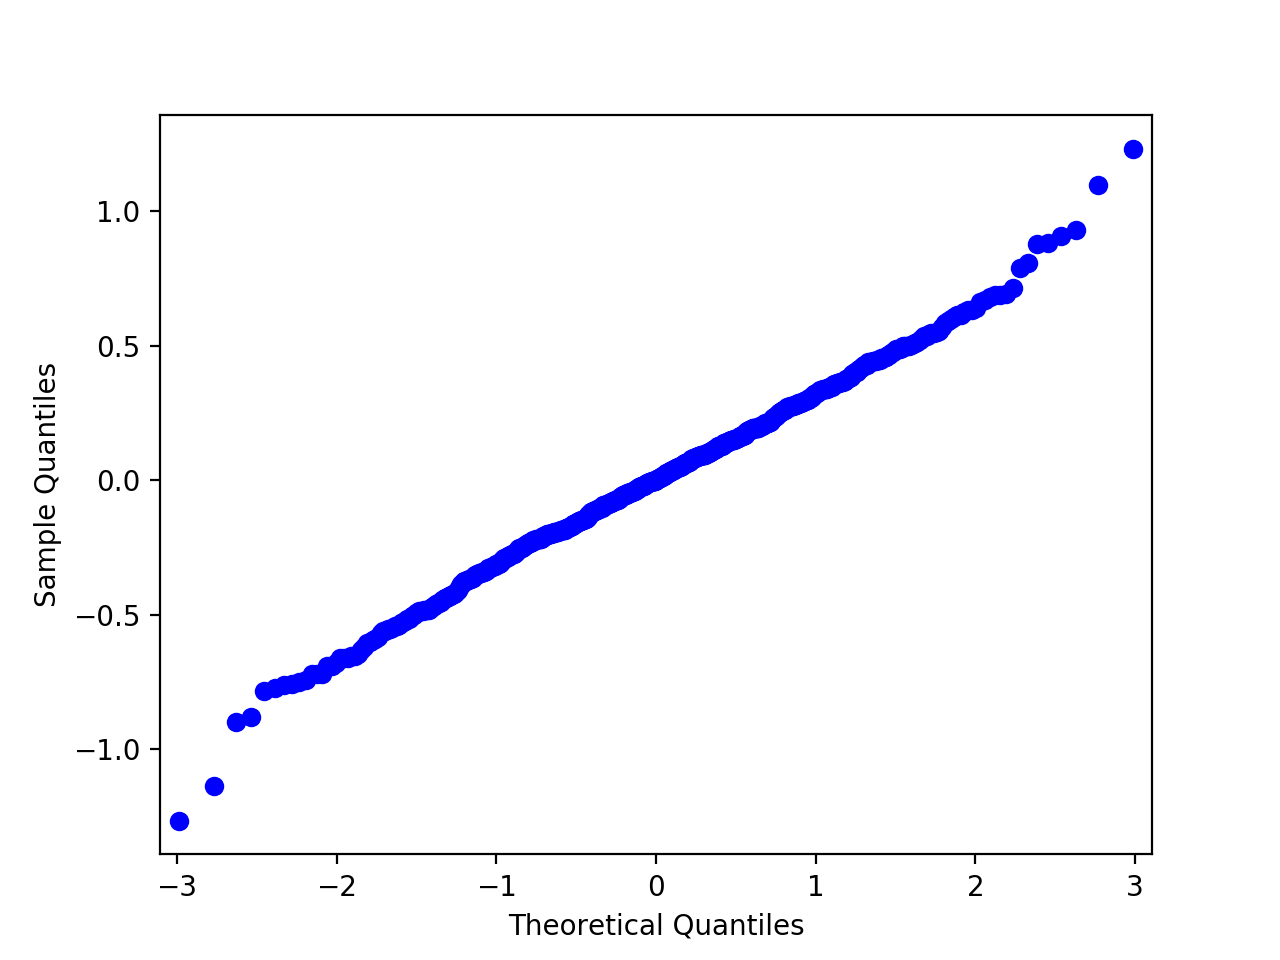

<IPython.core.display.Javascript object>


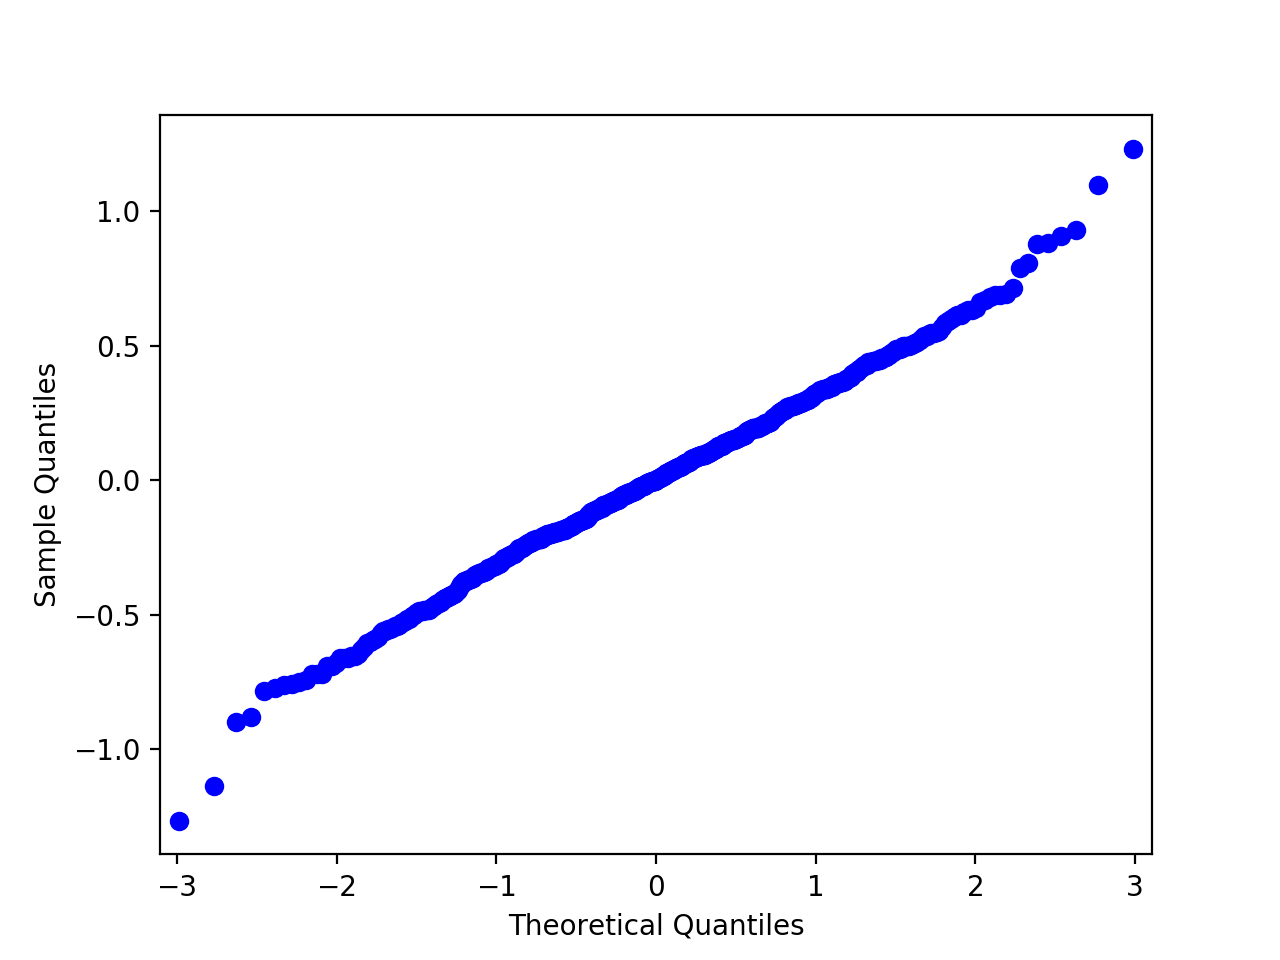

In [474]:
res = df.residuals_differenced.values
sm.qqplot(res)

### Check if variance is constant across years

Using bartlett-test (if normal) or Levene (non-normal)

Both test the null-hypthesis that all samples are from populations with equal variance.
If we observe a low p-value we reject the null-hypthesis and the variances are therefore different across years.

The Bartlett-test is sensitive to deviations from normality.

In [475]:
res = df.residuals_differenced.values.reshape((59,12))
ss.levene(*res)

LeveneResult(statistic=1.5367716443942787, pvalue=0.008076213408665548)

In [476]:
ss.bartlett(*res)

BartlettResult(statistic=105.99895482831622, pvalue=0.00012240843811629147)

### Ljung-box test to check for correlation between lags

In [477]:
from statsmodels.stats.diagnostic import acorr_ljungbox
result = acorr_ljungbox(df.residuals_differenced, lags = 24)

In [478]:
result

(array([36.73336384, 39.45015315, 49.1576148 , 53.17623354, 57.06353388,
        57.75513713, 59.01104067, 59.85481657, 59.85486452, 60.43692627,
        65.03427227, 71.42173271, 72.95785996, 73.32580769, 81.91732971,
        81.93420766, 84.34602272, 84.63593488, 84.74371951, 86.26256474,
        87.0948622 , 87.15081851, 88.88808655, 94.12067659]),
 array([1.35441498e-09, 2.71336419e-09, 1.20746549e-10, 7.82797910e-11,
        4.90674752e-11, 1.28463003e-10, 2.37776402e-10, 4.97691616e-10,
        1.42984042e-09, 2.99575377e-09, 1.06175243e-09, 1.73442504e-10,
        2.28074042e-10, 4.79262939e-10, 3.11039907e-11, 7.44296490e-11,
        6.42053614e-11, 1.30758507e-10, 2.79205863e-10, 3.31289593e-10,
        5.09293667e-10, 1.04168997e-09, 1.09167235e-09, 2.96624433e-10]))

### Check if variance is constant

In [479]:
residuals = df.residuals_differenced.values

In [480]:
len(residuals)

708

In [481]:
print(np.var(residuals))

0.1066366356923441


In [482]:
res1,res2,res3,res4,res5,res6,res7,res8,res9,res10,res11,res12 = np.split(residuals, 12)

In [483]:
print(np.var(res1))
print(np.var(res2))
print(np.var(res3))
print(np.var(res4))
print(np.var(res5))
print(np.var(res6))
print(np.var(res7))
print(np.var(res8))
print(np.var(res9))
print(np.var(res10))
print(np.var(res11))
print(np.var(res12))

0.13368518322610157
0.10677803230945866
0.10442620639204743
0.057890076701241786
0.08682298667896936
0.07306513563974758
0.08245476049228431
0.07438401993108373
0.09700304079717223
0.15230050521628946
0.1076865420310517
0.20287682120605505


## ACF and PACF for ARMA-model

In [484]:
lag, autocorr = gen_autocorr(df.residuals_differenced_2)

<IPython.core.display.Javascript object>


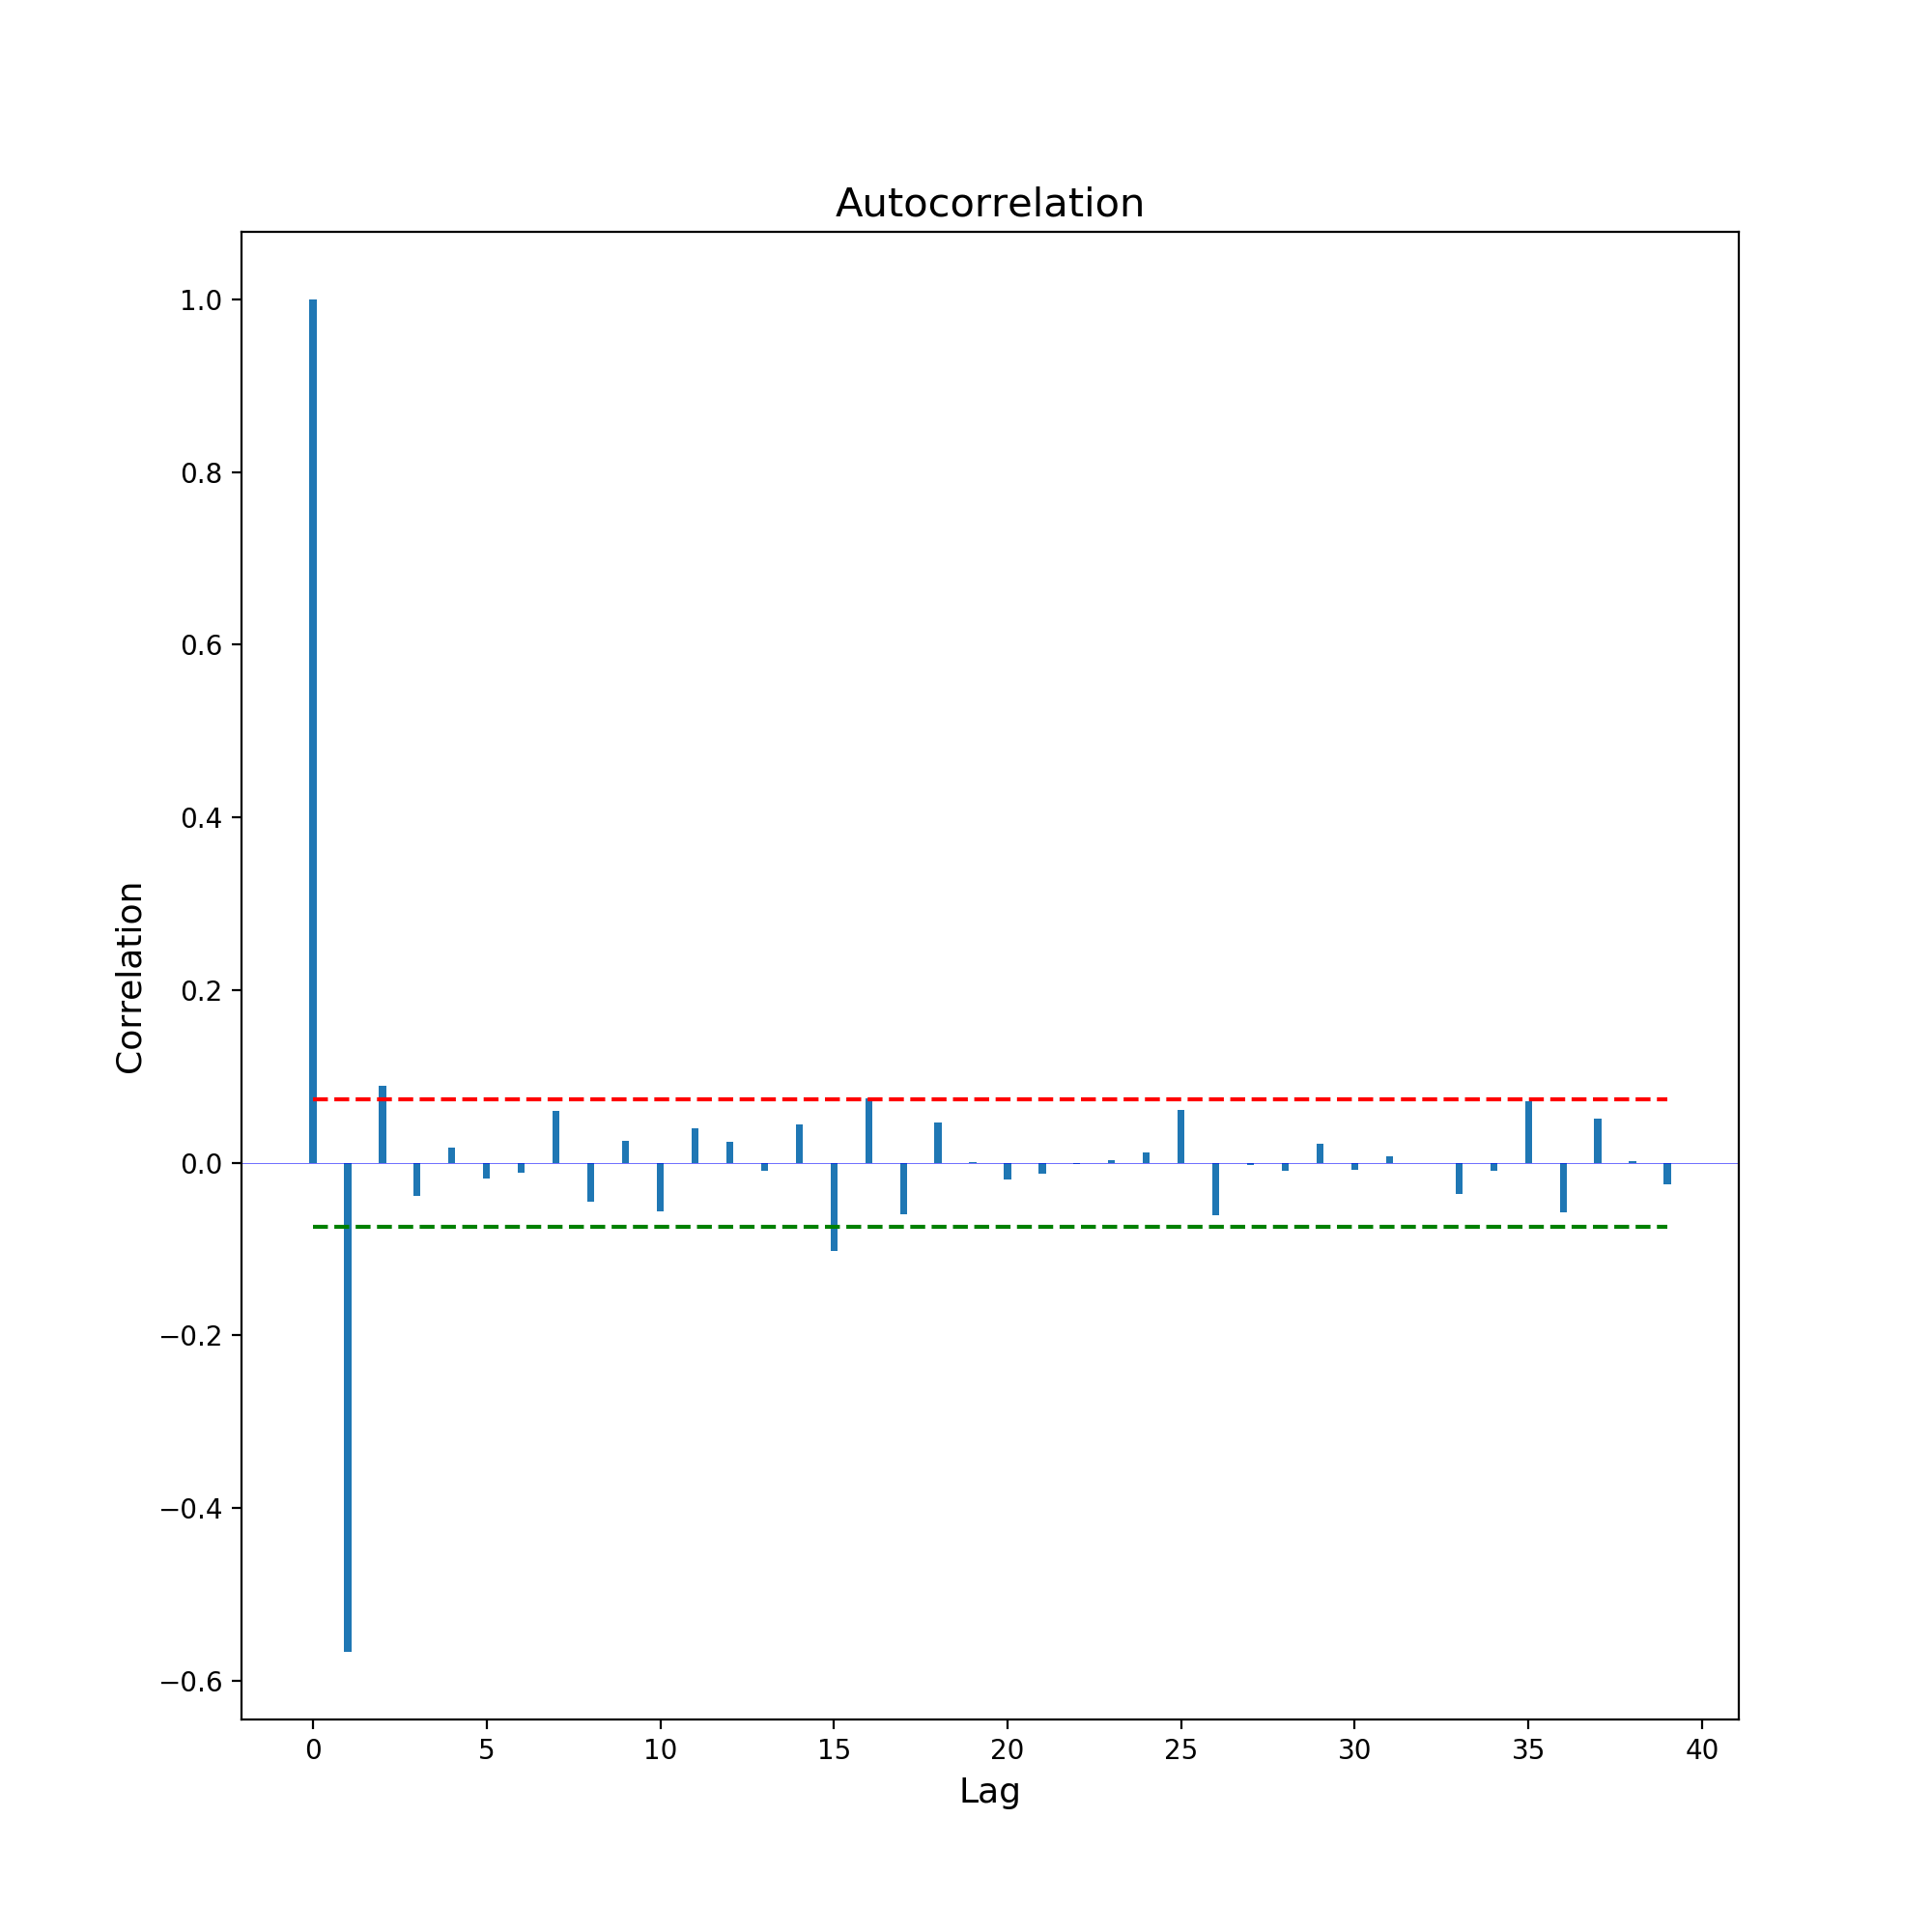

In [486]:
length_sequence = len(df.residuals_differenced_2)
# Boundarise
num = 1.96/np.sqrt(length_sequence)
upper = np.ones(2*length_sequence - 1)*num
lower = np.ones(2*length_sequence - 1)*(-num)

lim1 = length_sequence-1
lim2 = length_sequence-1+40

plt.figure(figsize=(10,10))
#plt.plot(lag[lim1:lim2], autocorr_residuals[lim1:lim2], lag[lim1:lim2], upper[lim1:lim2], lag[lim1:lim2], lower[lim1:lim2])
plt.bar(lag[lim1:lim2], autocorr[lim1:lim2], width=0.2)
plt.plot(lag[lim1:lim2], upper[lim1:lim2], 'r--',lag[lim1:lim2], lower[lim1:lim2],'g--')
plt.title('Autocorrelation', fontsize = 15)
plt.axhline(0, color='blue',lw=0.2)
plt.xlabel('Lag', fontsize=13)
plt.ylabel('Correlation', fontsize=13)
plt.show()

### Autocorrelation - Original Data

<IPython.core.display.Javascript object>


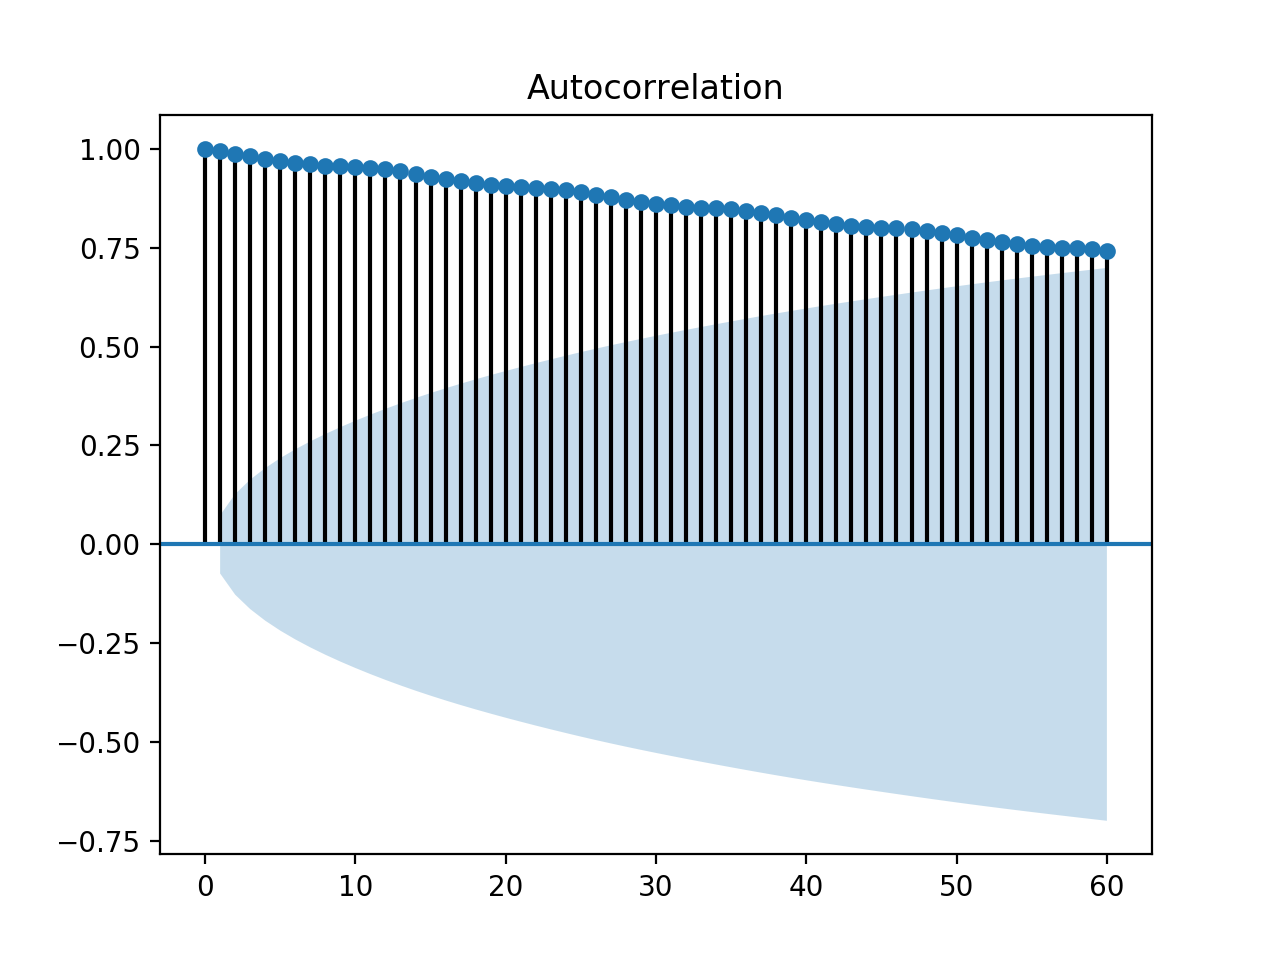

<IPython.core.display.Javascript object>


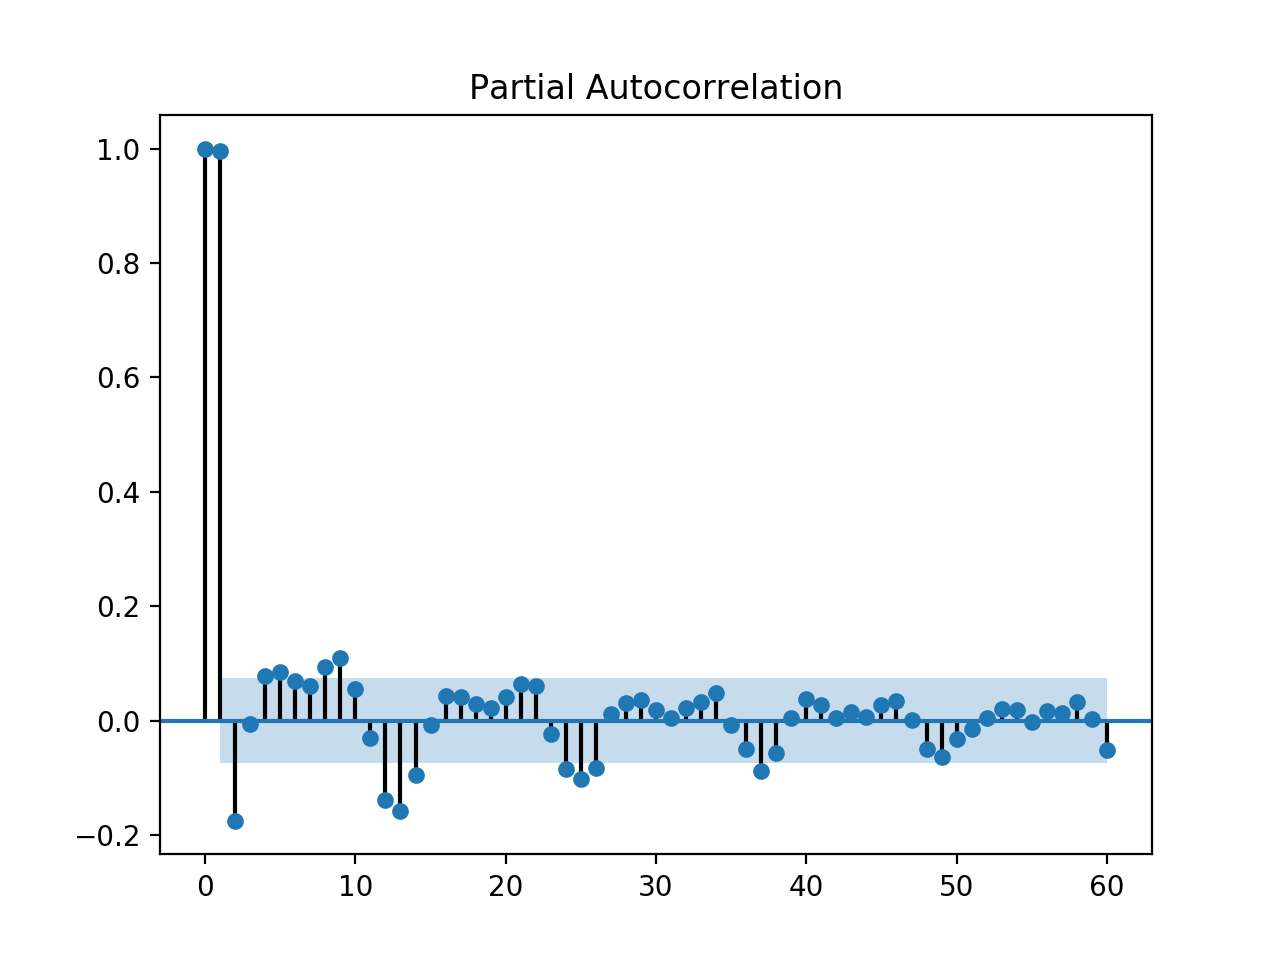

<IPython.core.display.Javascript object>


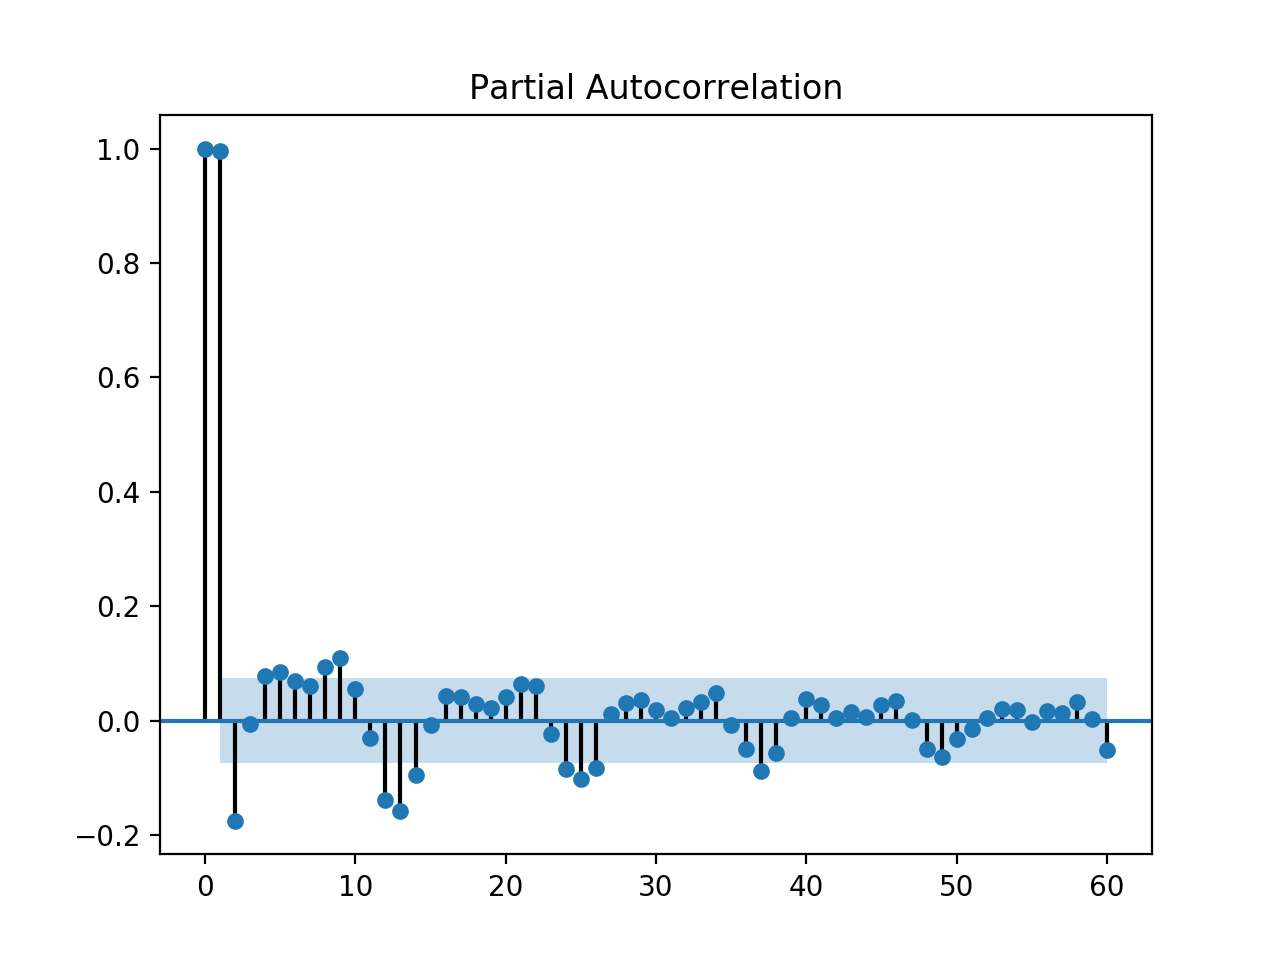

In [487]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.CO2,lags=60)
plot_pacf(df.CO2,lags=60)

### Autocorrelation - Originale Residualer

<IPython.core.display.Javascript object>


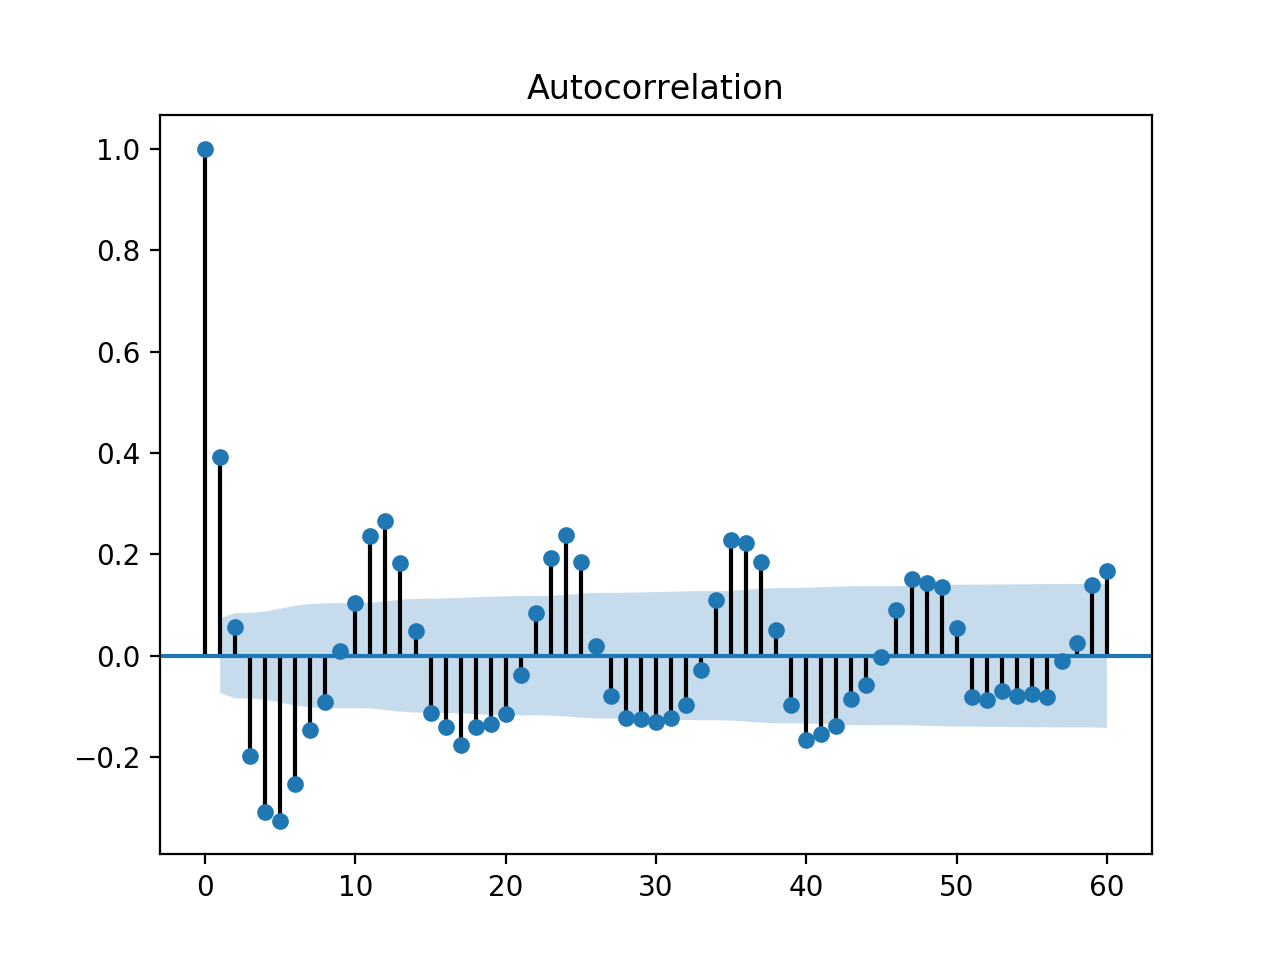

<IPython.core.display.Javascript object>


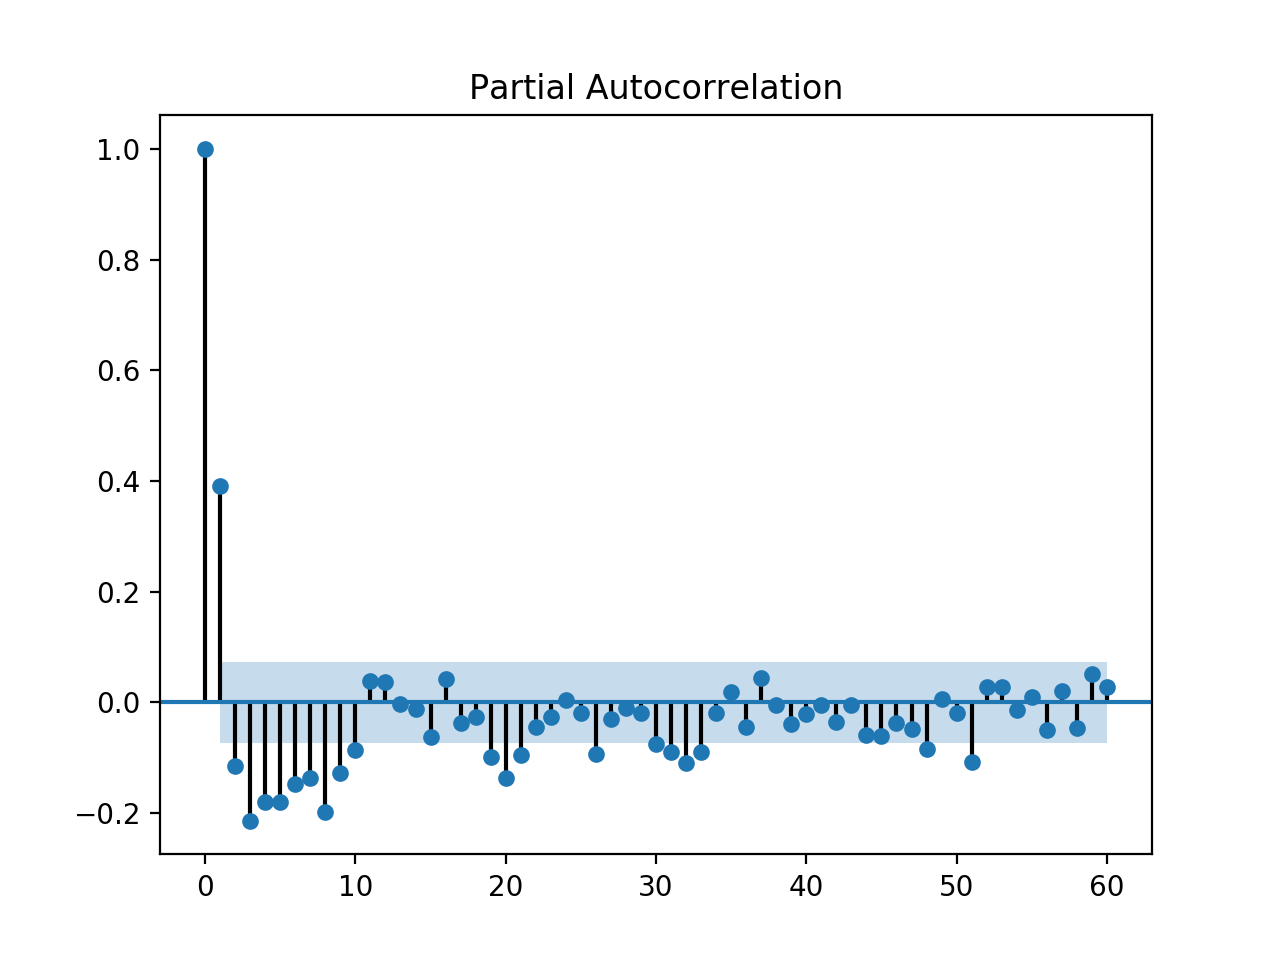

<IPython.core.display.Javascript object>


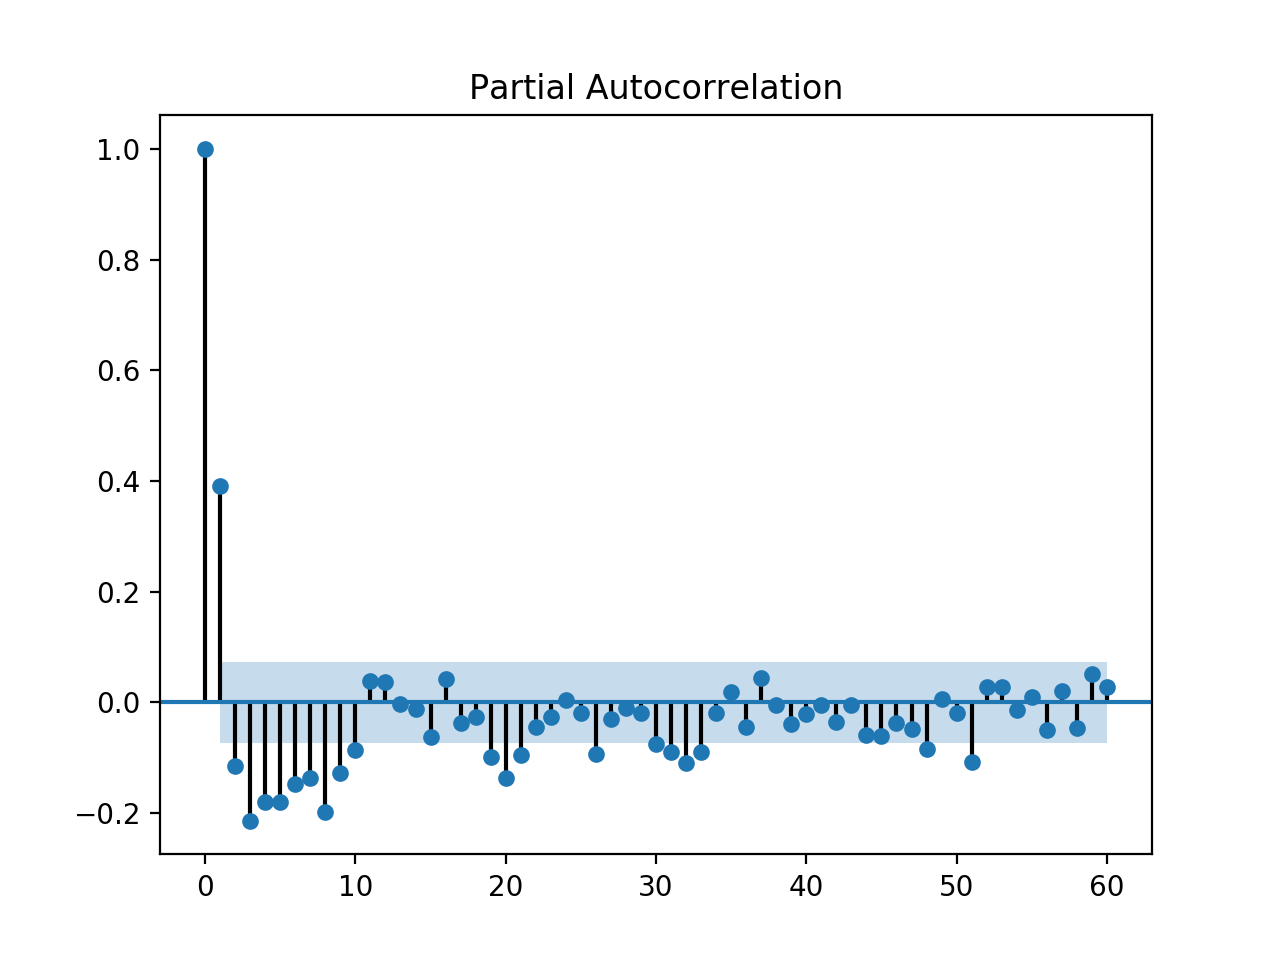

In [488]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.residuals,lags=60)
plot_pacf(df.residuals,lags=60)

### Autocorrelation - Residualer Differenced - 1

<IPython.core.display.Javascript object>


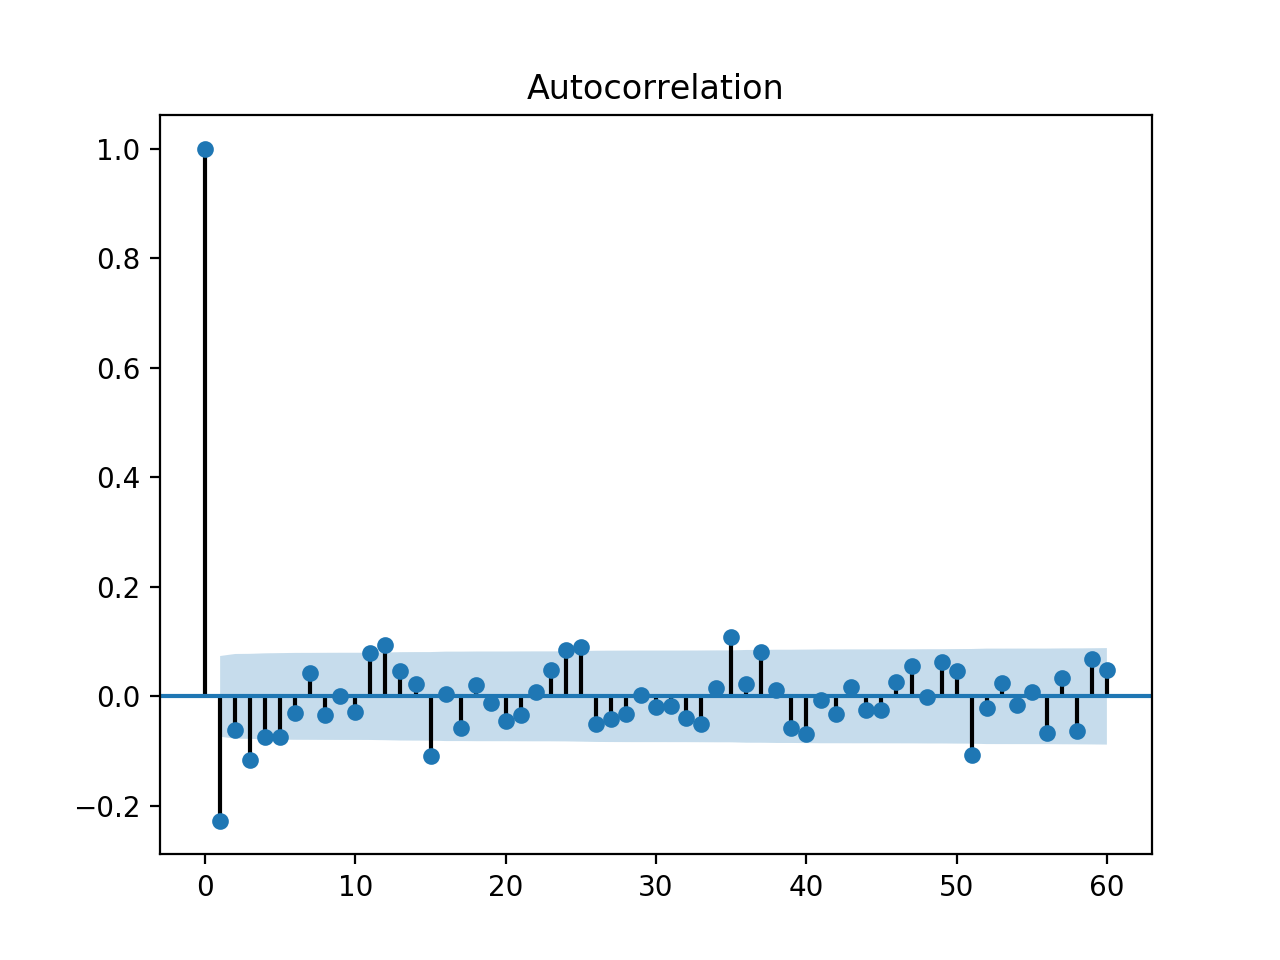

<IPython.core.display.Javascript object>


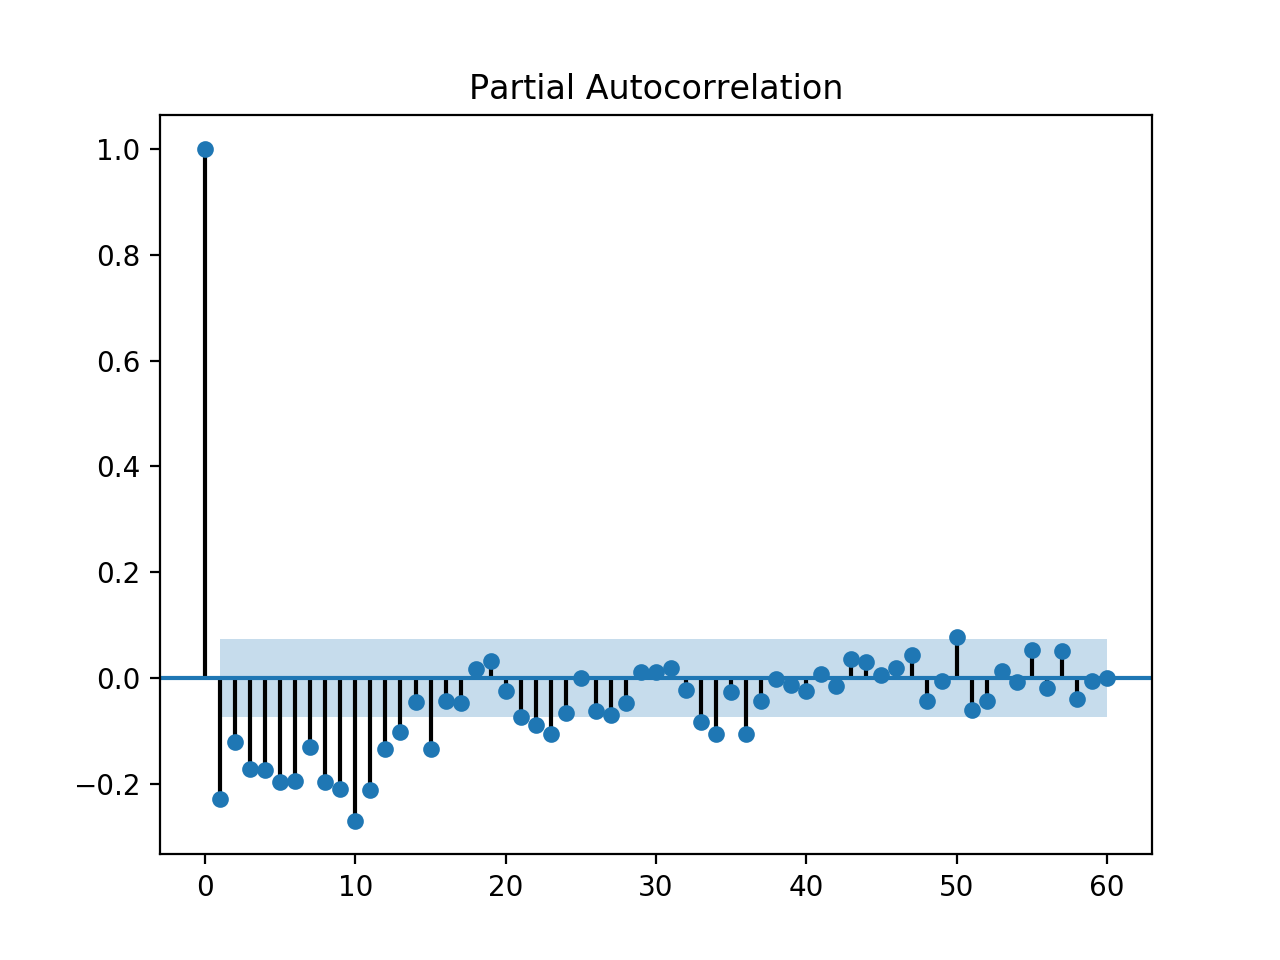

<IPython.core.display.Javascript object>


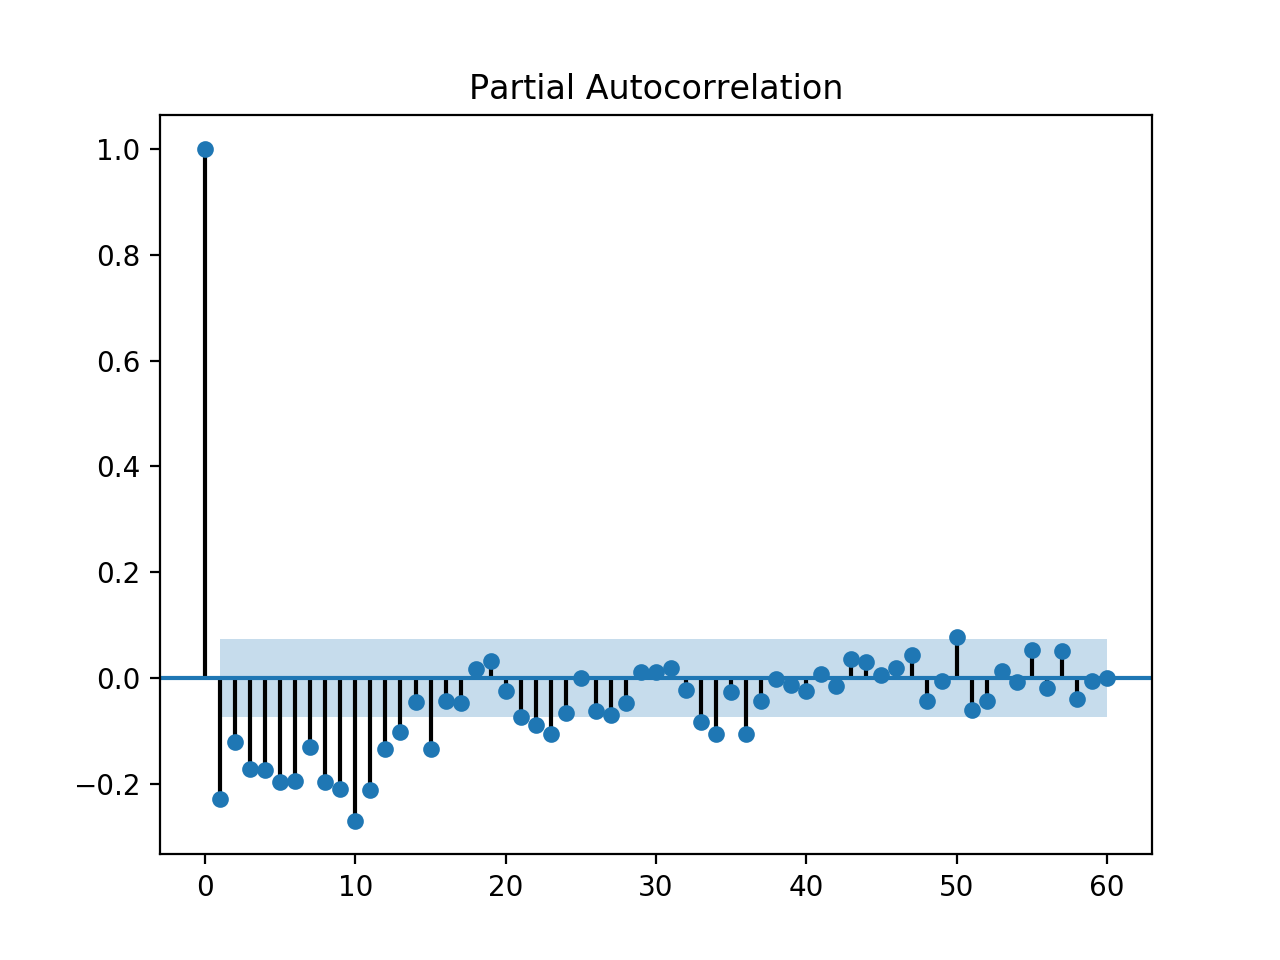

In [489]:
plot_acf(df.residuals_differenced,lags=12*5)
plot_pacf(df.residuals_differenced,lags=12*5)

### Autocorrelation - Residualer Final

<IPython.core.display.Javascript object>


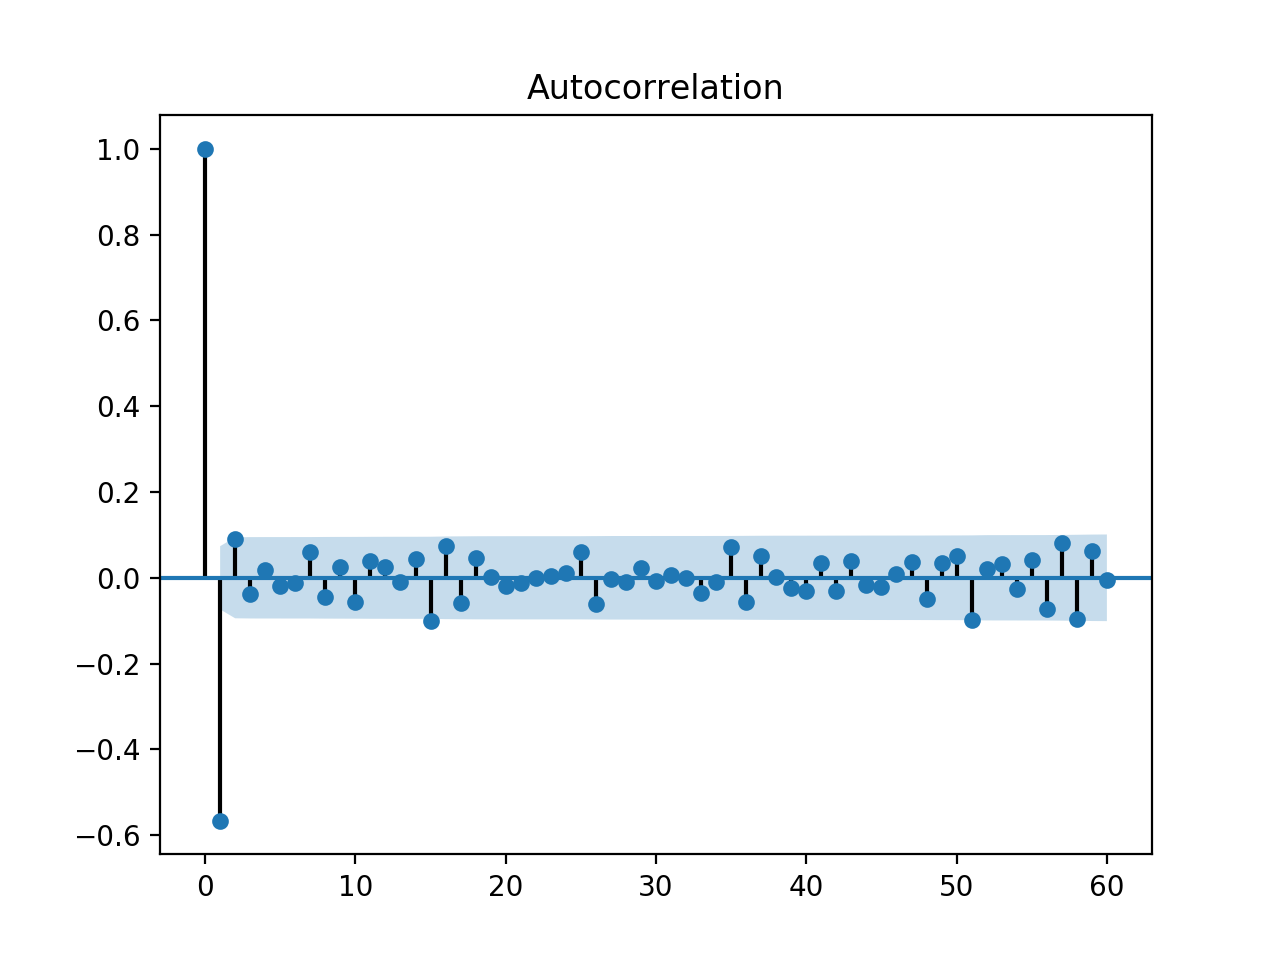

<IPython.core.display.Javascript object>


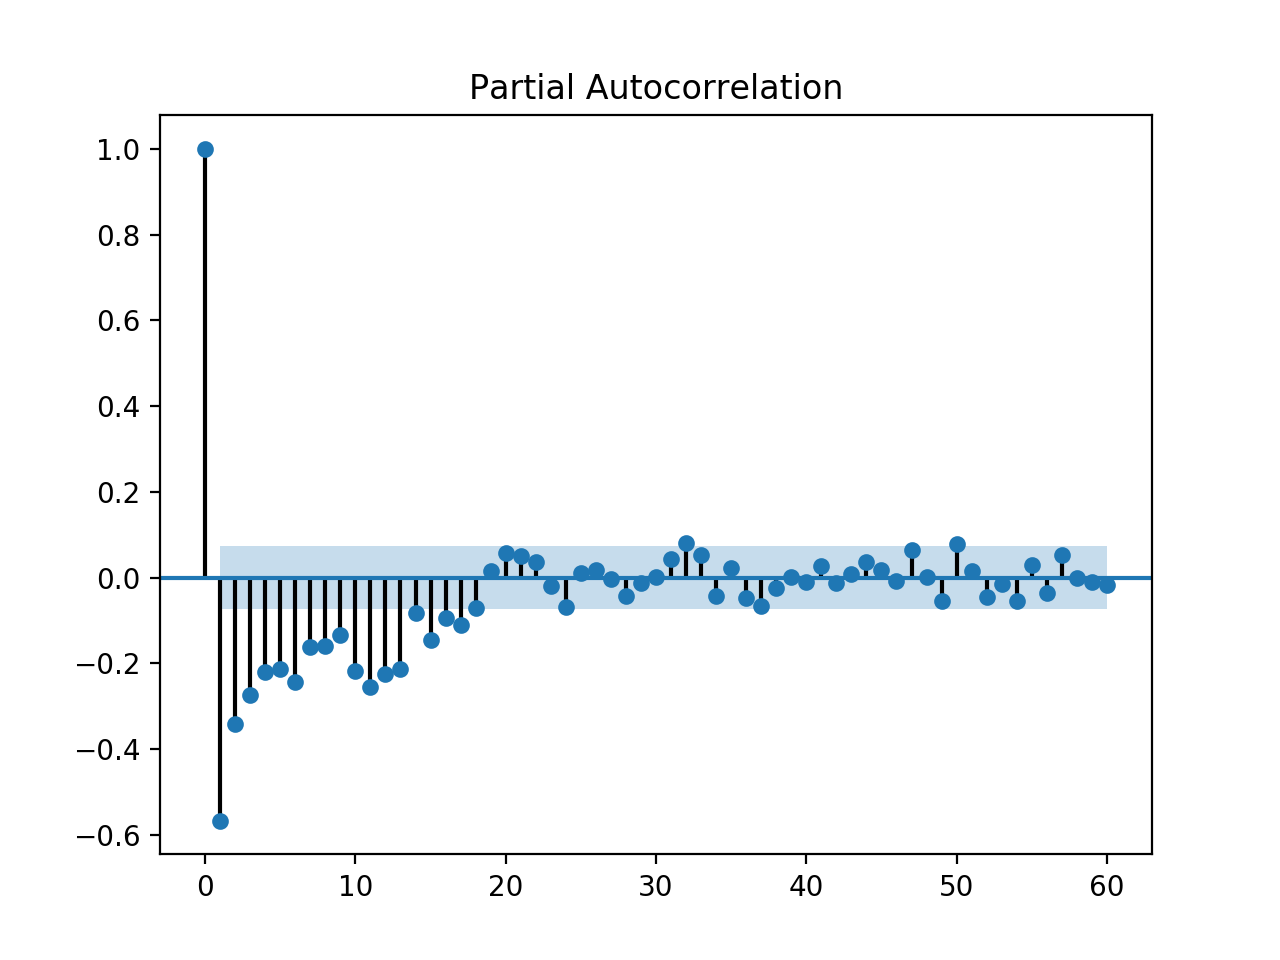

<IPython.core.display.Javascript object>


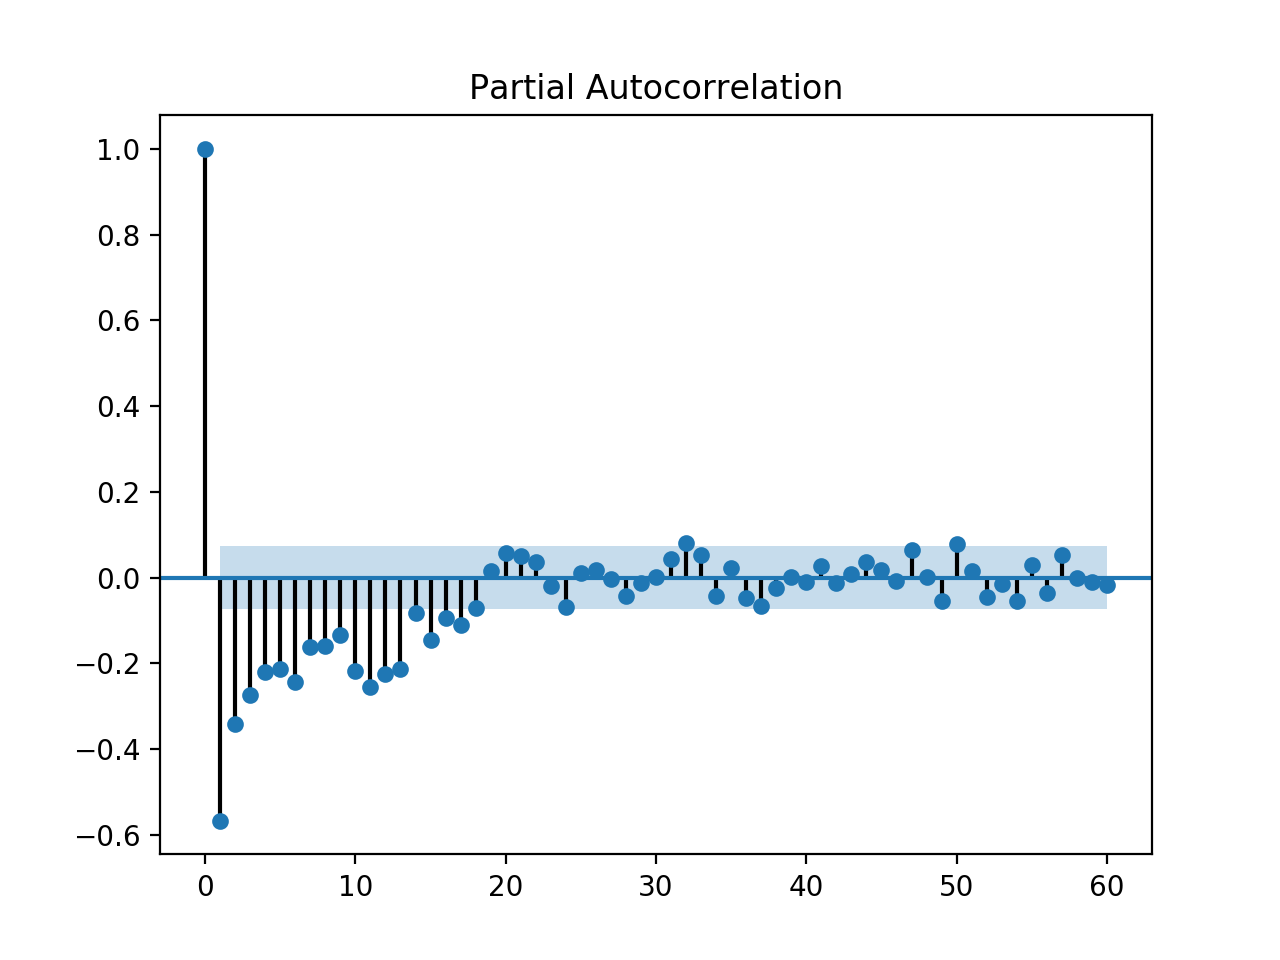

In [490]:
plot_acf(df.residuals_differenced_2,lags=60)
plot_pacf(df.residuals_differenced_2,lags=60)

## ARMA Model

In [491]:
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(df.residuals_differenced_2, order=(12,2)) #order=(p,q)
result = mod.fit()

/Users/Eirik/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/Eirik/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Eirik/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [492]:
result.aic #AIC value

128.44765932728433

<IPython.core.display.Javascript object>


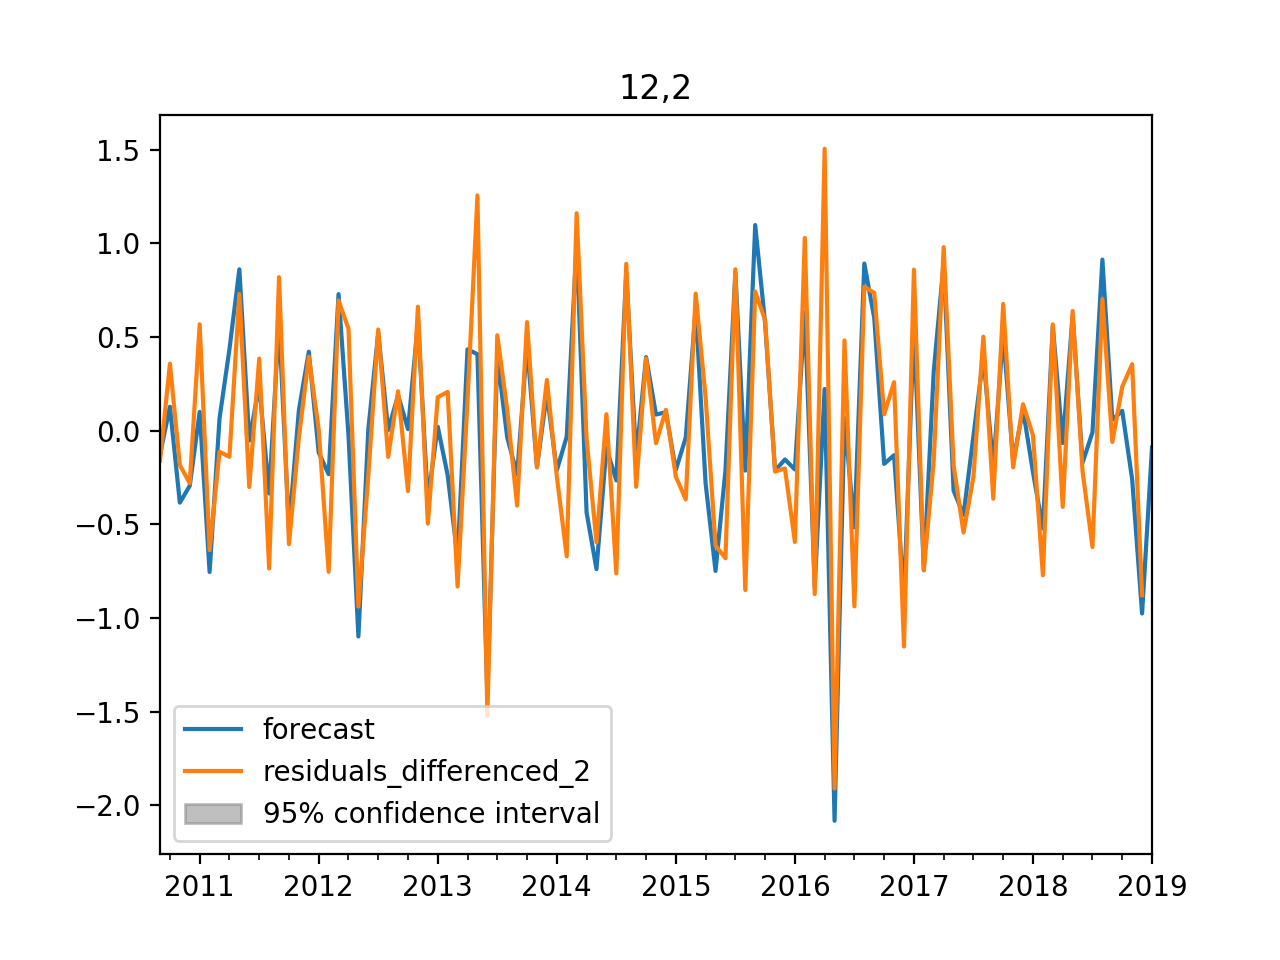

Text(0.5, 1.0, '12,2')

In [493]:
result.plot_predict(start=length_sequence-100, end=length_sequence)
plt.title("12,2")